In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA 
from statsmodels.sandbox.stats.multicomp import multipletests 

from snmcseq_utils import plot_tsne_values
from snmcseq_utils import plot_tsne_labels
from snmcseq_utils import tsne_and_boxplot

In [2]:
cell_types = ['hDL-1', 'hDL-2', 'hDL-3', 'hL2/3', 'hL4', 'hL5-1', 'hL5-2', 'hL5-3',
       'hL5-4', 'hL6-1', 'hL6-2', 'hL6-3', 'hNdnf', 'hNos', 'hPv-1',
       'hPv-2', 'hSst-1', 'hSst-2', 'hSst-3', 'hVip-1', 'hVip-2', 'unlabeled']

cell_classes = ['exci', 'exci', 'exci', 'exci', 'exci', 'exci', 'exci', 'exci',
       'exci', 'exci', 'exci', 'exci', 'inhi', 'inhi', 'inhi',
       'inhi', 'inhi', 'inhi', 'inhi', 'inhi', 'inhi', 'glia']

df_cell_class = pd.DataFrame()
df_cell_class['cell_type'] = cell_types
df_cell_class['cell_class'] = cell_classes
df_cell_class = df_cell_class.set_index('cell_type')
df_cell_class

cell_class
cell_type           
hDL-1           exci
hDL-2           exci
hDL-3           exci
hL2/3           exci
hL4             exci
hL5-1           exci
hL5-2           exci
hL5-3           exci
hL5-4           exci
hL6-1           exci
hL6-2           exci
hL6-3           exci
hNdnf           inhi
hNos            inhi
hPv-1           inhi
hPv-2           inhi
hSst-1          inhi
hSst-2          inhi
hSst-3          inhi
hVip-1          inhi
hVip-2          inhi
unlabeled       glia

In [3]:
mc_c_file = './data/gene_level/genebody_mCH_human_combined_summary.tsv'
df = pd.read_table(mc_c_file, index_col='id')
print(df.shape)

(57240, 12870)


In [4]:
meta_file = './data/metadata/metadata_human_combined_updated.tsv' 
cluster_file = './data/cluster/cluster_MB_v1_MB_EA_MB_EB/clusters_v1_binc_mCH_louvain.tsv'
tsne_file = './data/tsne/tsne_perp30_binc_mCH_human_combined_100000_summary_nmcc_v3.tsv'
gene_id_name_file = './data/references/gene_id_to_names.tsv'
annotation_file = './data/cluster/cluster_MB_v1_MB_EA_MB_EB/clusters_v1_binc_mCH_louvain_annotation.tsv'

df_meta = pd.read_table(meta_file, index_col='Sample')
df_cluster = pd.read_table(cluster_file, index_col='sample')
df_tsne = pd.read_table(tsne_file, index_col='sample')
df_gene = pd.read_table(gene_id_name_file, index_col='geneID')
df_annot = pd.read_table(annotation_file, index_col='cluster_ID').fillna('unlabeled')

df_cluster = pd.merge(df_cluster, df_annot, left_on='cluster_ID', right_index=True)
df_cluster = pd.merge(df_cluster, df_cell_class, left_on='cluster_annotation', right_index=True)

print(df_meta.shape)
print(df_tsne.shape)
print(df_cluster.shape)
print(df_gene.shape)

df_info = pd.merge(df_meta, df_cluster, left_index=True, right_index=True)
df_info = pd.merge(df_info, df_tsne, left_index=True, right_index=True)
print(df_info.shape)

(6435, 16)
(6435, 2)
(6435, 3)
(57820, 5)
(6435, 21)


In [5]:
df_mc = df.filter(regex='_mc')
df_c = df.filter(regex='_c')

df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns]
df_c.columns = [col[:-len('_c')] for col in df_c.columns]

print(df_mc.shape)
print(df_c.shape)


# cells = df_info[df_info.cluster_ID=='cluster_52'].index.values
# cells_1 = df_info[(df_info.cluster_ID=='cluster_52') & (df_info.Biosample=='MB_v1')].index.values
# cells_2 = df_info[(df_info.cluster_ID=='cluster_52') & (df_info.Biosample=='MB_EA')].index.values
# cells_3 = df_info[(df_info.cluster_ID=='cluster_52') & (df_info.Biosample=='MB_EB')].index.values
# print(cells.shape)
# print(cells_1.shape)
# print(cells_2.shape)
# print(cells_3.shape)

(57240, 6435)
(57240, 6435)


In [6]:
# filter out genes with low coverage
# doing imputation
# get gene*cell matrix

# cutoff = 100
# cov = (df_c >= cutoff)*1
# gene_cov = cov.apply(np.all, axis=1)
# df_mccf = df_mcc.loc[gene_cov, :]
# print(df_mccf.shape)
# sns.heatmap(cov)
# plt.show()# low coverage


# remove low coverage gene

base_call_cutoff = 100 
sufficient_coverage_fraction = 0.98 
condition = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 


print("Matrix size before pruning... "+ str(df.shape))
df_f = df.loc[condition]
print("Matrix size after pruning... "+ str(df_f.shape))

# get mcc matrix with kept bins and nan values for low coverage sites
df_c_nan = df_c.copy()
df_c_nan[df_c < base_call_cutoff] = np.nan
df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]
print(df_mcc.shape)

# imputation (missing value -> mean value of all cells)
print('Imputing data...')
means = df_mcc.mean(axis=1)
fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
df_mcc.fillna(fill_value, inplace=True)

# add "_mcc" suffix
df_mcc.columns = df_mcc.columns.values + '_mcc'


Matrix size before pruning... (57240, 12870)
Matrix size after pruning... (10142, 12870)
(10142, 6435)
Imputing data...


# End of preprocessing

2784
2347
1304


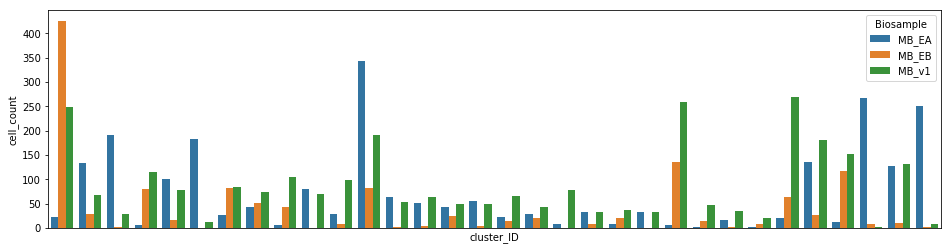

In [12]:
"""
For every cluster, plot biosample related quantities
"""
cell_count1 = df_info[df_info.Biosample=='MB_v1'].shape[0]
cell_count2 = df_info[df_info.Biosample=='MB_EA'].shape[0]
cell_count3 = df_info[df_info.Biosample=='MB_EB'].shape[0]
print(cell_count1)
print(cell_count2)
print(cell_count3)

df_counts = df_info.groupby(['cluster_ID', 'Biosample']).count()['mCH/CH'].to_frame()
df_counts.reset_index(level=['cluster_ID', 'Biosample'], inplace=True)
df_counts.columns = ['cluster_ID', 'Biosample', 'cell_count']

fig, ax = plt.subplots(figsize=(16, 4))
ax = sns.barplot(x="cluster_ID", y="cell_count", hue="Biosample", data=df_counts)
ax.set_xticks([])
plt.show()

In [17]:
df_sample_counts = df_info.groupby('Biosample').count()['mCH/CH'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new = pd.merge(df_counts, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new['cell_ratio'] = df_counts_new.cell_count/df_counts_new.tc_biosample


df_cluster_counts = df_info.groupby('cluster_ID').count()['mCH/CH'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new = pd.merge(df_counts_new, df_cluster_counts, left_on='cluster_ID', right_index=True)
df_counts_new['cell_ratio_cluster'] = df_counts_new.cell_ratio/df_counts_new.tc_cluster

print(df_counts_new.shape)
df_counts_new.head()

(92, 7)


cluster_ID Biosample  cell_count  tc_biosample  cell_ratio  tc_cluster  \
0   cluster_1     MB_EA          23          2347    0.009800         698   
1   cluster_1     MB_EB         426          1304    0.326687         698   
2   cluster_1     MB_v1         249          2784    0.089440         698   
3  cluster_10     MB_EA         134          2347    0.057094         230   
4  cluster_10     MB_EB          28          1304    0.021472         230   

   cell_ratio_cluster  
0            0.000014  
1            0.000468  
2            0.000128  
3            0.000248  
4            0.000093

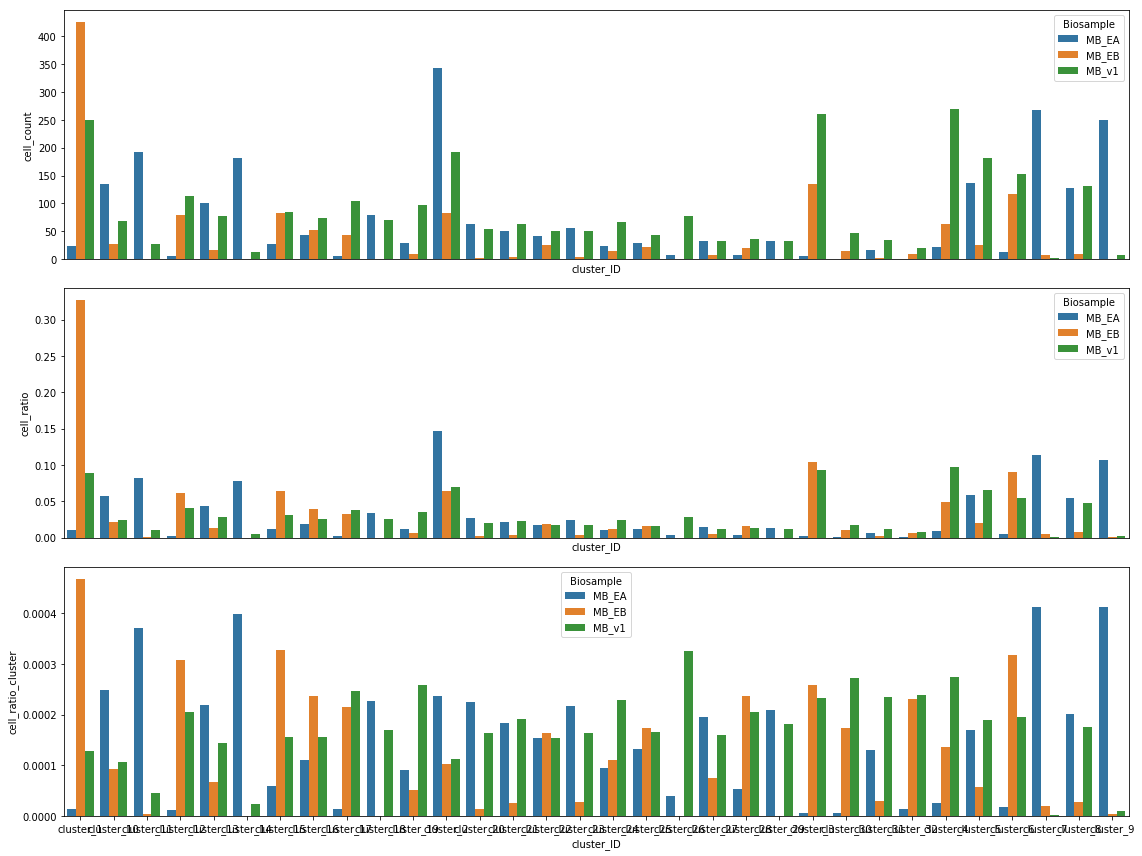

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cluster_ID", y="cell_count", hue="Biosample", data=df_counts_new, ax=ax)
ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cluster_ID", y="cell_ratio", hue="Biosample", data=df_counts_new, ax=ax)
ax.set_xticks([])
ax = axs[2]
sns.barplot(x="cluster_ID", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new, ax=ax)
# ax.set_xticks([])
fig.tight_layout()
plt.show()

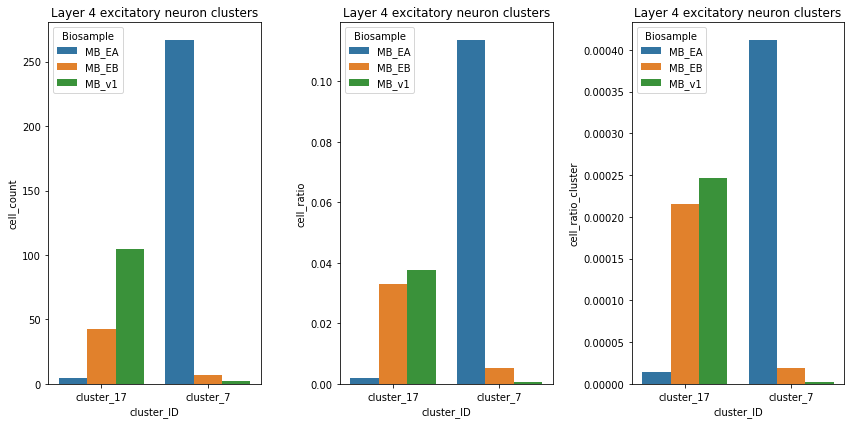

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
ax = axs[0]
sns.barplot(x="cluster_ID", y="cell_count", hue="Biosample", data=df_counts_new[df_counts_new.cluster_ID.isin(['cluster_7', 'cluster_17'])], ax=ax)
# ax.set_xticks([])
ax.set_title('Layer 4 excitatory neuron clusters')
ax = axs[1]
sns.barplot(x="cluster_ID", y="cell_ratio", hue="Biosample", data=df_counts_new[df_counts_new.cluster_ID.isin(['cluster_7', 'cluster_17'])], ax=ax)
# ax.set_xticks([])
ax.set_title('Layer 4 excitatory neuron clusters')
ax = axs[2]
sns.barplot(x="cluster_ID", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new[df_counts_new.cluster_ID.isin(['cluster_7', 'cluster_17'])], ax=ax)
ax.set_title('Layer 4 excitatory neuron clusters')
fig.tight_layout()
plt.show()

In [33]:
df_counts_2 = df_info.groupby(['cluster_annotation', 'Biosample']).count()['mCH/CH'].to_frame()
df_counts_2 = df_counts_2.reset_index(level=['cluster_annotation', 'Biosample'])
df_counts_2.columns = ['cluster_annotation', 'Biosample', 'cell_count']

df_sample_counts = df_info.groupby('Biosample').count()['mCH/CH'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new_2 = pd.merge(df_counts_2, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new_2['cell_ratio'] = df_counts_new_2.cell_count/df_counts_new_2.tc_biosample

df_cluster_counts = df_info.groupby('cluster_annotation').count()['mCH/CH'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new_2 = pd.merge(df_counts_new_2, df_cluster_counts, left_on='cluster_annotation', right_index=True)
df_counts_new_2['cell_ratio_cluster'] = df_counts_new_2.cell_ratio/df_counts_new_2.tc_cluster

df_counts_new_2.head()

array(['hDL-1', 'hDL-2', 'hL2/3', 'hL4', 'hL5-1', 'hL5-2', 'hL5-3',
       'hL5-4', 'hL6-1', 'hL6-2', 'hL6-3', 'hNdnf', 'hNos', 'hPv-1',
       'hPv-2', 'hSst-2', 'hSst-3', 'hVip-1', 'hVip-2'], dtype=object)

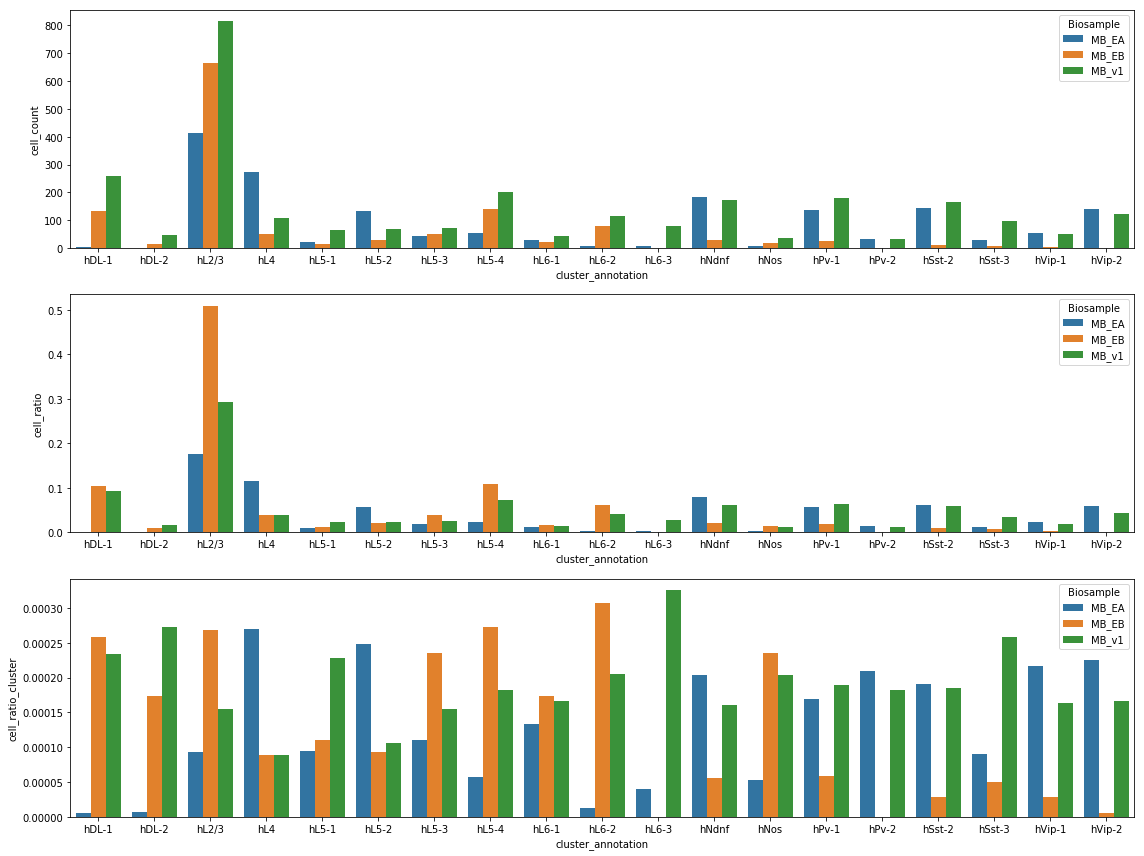

In [31]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cluster_annotation", y="cell_count", hue="Biosample", data=df_counts_new_2, ax=ax)
# ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cluster_annotation", y="cell_ratio", hue="Biosample", data=df_counts_new_2, ax=ax)
# ax.set_xticks([])
ax = axs[2]
sns.barplot(x="cluster_annotation", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new_2, ax=ax)
fig.tight_layout()
plt.show()

In [61]:
df_counts_3 = df_info.groupby(['cell_class', 'Biosample']).count()['mCH/CH'].to_frame()
df_counts_3 = df_counts_3.reset_index(level=['cell_class', 'Biosample'])
df_counts_3.columns = ['cell_class', 'Biosample', 'cell_count']

df_sample_counts = df_info.groupby('Biosample').count()['mCH/CH'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new_3 = pd.merge(df_counts_3, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new_3['cell_ratio'] = df_counts_new_3.cell_count/df_counts_new_3.tc_biosample

df_cluster_counts = df_info.groupby('cell_class').count()['mCH/CH'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new_3 = pd.merge(df_counts_new_3, df_cluster_counts, left_on='cell_class', right_index=True)
df_counts_new_3['cell_ratio_cluster'] = df_counts_new_3.cell_ratio/df_counts_new_3.tc_cluster

df_counts_new_3

cell_class Biosample  cell_count  tc_biosample  cell_ratio  tc_cluster  \
0       exci     MB_EA         991          2347    0.422241        4066   
1       exci     MB_EB        1201          1304    0.921012        4066   
2       exci     MB_v1        1874          2784    0.673132        4066   
3       glia     MB_EA         624          2347    0.265871         674   
4       glia     MB_EB           2          1304    0.001534         674   
5       glia     MB_v1          48          2784    0.017241         674   
6       inhi     MB_EA         732          2347    0.311888        1695   
7       inhi     MB_EB         101          1304    0.077454        1695   
8       inhi     MB_v1         862          2784    0.309626        1695   

   cell_ratio_cluster  
0            0.000104  
1            0.000227  
2            0.000166  
3            0.000394  
4            0.000002  
5            0.000026  
6            0.000184  
7            0.000046  
8            0.000183

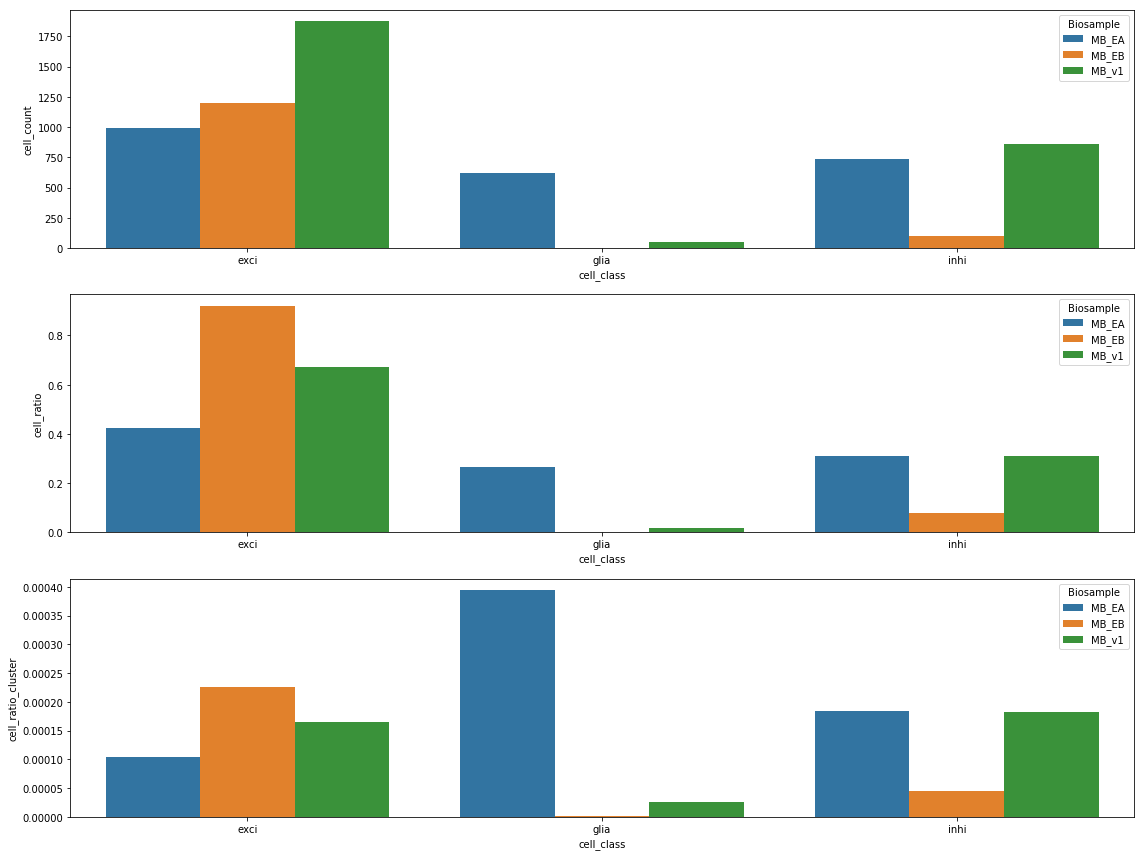

In [62]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cell_class", y="cell_count", hue="Biosample", data=df_counts_new_3, ax=ax)
# ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cell_class", y="cell_ratio", hue="Biosample", data=df_counts_new_3, ax=ax)
# ax.set_xticks([])
ax = axs[2]
sns.barplot(x="cell_class", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new_3, ax=ax)
fig.tight_layout()
plt.show()

# Analysis of variances

In [7]:
def sum_of_square(array):
    dev = array - np.mean(array)
    return np.dot(dev, dev)

In [9]:
# cells with 2 biosamples only 
df_info = df_info[df_info.Biosample.isin(['MB_v1', 'MB_EA'])]
df_mcc = df_mcc[df_info.index.values+'_mcc']
print(df_info.shape)
print(df_mcc.shape)

(5131, 21)
(10142, 5131)


# ANOVAs for each gene and each cluster

In [16]:
# ANOVAs for each gene

# sst ssw sr_n

df_sst = pd.DataFrame()
df_ssw = pd.DataFrame()
sr_n = pd.Series()
for idx, df_sub in df_info.groupby('cluster_annotation'):
    cells = df_sub.index.values
    SSt = df_mcc[cells+'_mcc'].apply(sum_of_square, axis=1)
    SSw = 0
    for idx2, df_sub2 in df_sub.groupby('Biosample'):
        cells_bio = df_sub2.index.values
        SSw += df_mcc[cells_bio+'_mcc'].apply(sum_of_square, axis=1)
    df_sst[idx] = SSt 
    df_ssw[idx] = SSw 
    sr_n[idx] = cells.shape[0]
 

In [17]:
# F-stat, p-values

I = 2
df_F = ((df_sst - df_ssw)/(I-1))/(df_ssw.divide(sr_n-I, axis=1))
df_p = pd.DataFrame()
for col in df_F.columns:
    d2 = sr_n.loc[col] - I
    df_p[col] = df_F[col].apply(lambda x: stats.f.sf(x, I-1, d2))
df_p.head()

hDL-1     hDL-2         hL2/3       hL4     hL5-1  \
id                                                                         
ENSG00000000457.9   0.203185  0.704187  2.023110e-01  0.550655  0.851728   
ENSG00000000460.12  0.423332  0.273460  1.097477e-77  0.103922  0.000097   
ENSG00000000971.11  0.973508  0.012070  8.653164e-28  0.000133  0.452565   
ENSG00000001084.6   0.017328  0.196670  7.676728e-33  0.026545  0.665100   
ENSG00000001460.13  0.573414  0.869580  2.494198e-53  0.412131  0.069880   

                       hL5-2     hL5-3         hL5-4     hL6-1     hL6-2  \
id                                                                         
ENSG00000000457.9   0.884770  0.258117  3.302940e-02  0.621017  0.798966   
ENSG00000000460.12  0.798041  0.006878  5.315494e-04  0.269187  0.227407   
ENSG00000000971.11  0.204929  0.634414  8.035514e-02  0.279439  0.048354   
ENSG00000001084.6   0.097597  0.500360  6.243281e-02  0.370567  0.276988   
ENSG00000001460.13  0.492489  0.000679  2.026528e-08  0.702600  0.156213   

                       hL6-3     hNdnf      hNos     hPv-1     hPv-2  \
id                                                                     
ENSG00000000457.9   0.155292  0.558257  0.765455  0.000096  0.933817   
ENSG00000000460.12  0.001393  0.169612  0.025270  0.000060  0.157032   
ENSG00000000971.11  0.089025  0.202280  0.542849  0.000002  0.383633   
ENSG00000001084.6   0.040610  0.044877  0.175405  0.000003  0.748600   
ENSG00000001460.13  0.679836  0.002140  0.043142  0.000210  0.122594   

                      hSst-2    hSst-3    hVip-1    hVip-2  unlabeled  
id                                                                     
ENSG00000000457.9   0.094672  0.959705  0.880631  0.960124   0.161595  
ENSG00000000460.12  0.662955  0.167595  0.887441  0.439086   0.000638  
ENSG00000000971.11  0.528909  0.094608  0.907910  0.802644   0.002494  
ENSG00000001084.6   0.409008  0.225707  0.288584  0.828878   0.627532  
ENSG00000001460.13  0.254262  0.202872  0.279589  0.971700   0.664053

In [18]:
df_sst.head()

hDL-1     hDL-2     hL2/3       hL4     hL5-1  \
id                                                                     
ENSG00000000457.9   0.024022  0.003178  0.060978  0.017654  0.006341   
ENSG00000000460.12  0.074088  0.009786  0.316578  0.020183  0.014261   
ENSG00000000971.11  0.048529  0.010580  0.208721  0.044329  0.012387   
ENSG00000001084.6   0.059704  0.010050  0.227710  0.054082  0.018944   
ENSG00000001460.13  0.099107  0.009769  0.380609  0.058014  0.051448   

                       hL5-2     hL5-3     hL5-4     hL6-1     hL6-2  \
id                                                                     
ENSG00000000457.9   0.021362  0.017646  0.018771  0.003143  0.011156   
ENSG00000000460.12  0.023218  0.030819  0.078153  0.022859  0.058642   
ENSG00000000971.11  0.038667  0.038859  0.059594  0.015879  0.033852   
ENSG00000001084.6   0.066238  0.053385  0.088074  0.032451  0.056188   
ENSG00000001460.13  0.081844  0.042164  0.145577  0.024252  0.063023   

                       hL6-3     hNdnf      hNos     hPv-1     hPv-2  \
id                                                                     
ENSG00000000457.9   0.003516  0.081715  0.003299  0.035861  0.004753   
ENSG00000000460.12  0.015672  0.058584  0.003438  0.090946  0.005501   
ENSG00000000971.11  0.015709  0.064257  0.005654  0.125442  0.007801   
ENSG00000001084.6   0.018927  0.104230  0.002249  0.064073  0.006988   
ENSG00000001460.13  0.011901  0.239114  0.018105  0.254958  0.019138   

                      hSst-2    hSst-3    hVip-1    hVip-2  unlabeled  
id                                                                     
ENSG00000000457.9   0.038239  0.025902  0.007070  0.060600   0.046016  
ENSG00000000460.12  0.091620  0.031560  0.007052  0.065412   0.018400  
ENSG00000000971.11  0.118047  0.061137  0.013796  0.097130   0.027008  
ENSG00000001084.6   0.125471  0.039896  0.017010  0.163287   0.043696  
ENSG00000001460.13  0.243381  0.143646  0.037638  0.448747   0.137003

In [19]:
# eta-squard and omega squared
df_eta = 1 - df_ssw/df_sst

# om_sqrd = (SSbetween - (DFbetween * MSwithin))/(SStotal + MSwithin)
I = 2
df_ome = (df_sst - df_ssw - (I-1)*df_ssw.divide(sr_n-I, axis=1))/(df_sst + df_ssw.divide(sr_n-I, axis=1))


def order_df_res(df_res):
    df_res_ordered = pd.DataFrame()
    for col in df_res.columns:
        df_res_ordered[col] = df_res[col].sort_values(ascending=False).values
    return df_res_ordered

## Plots of ANOVA

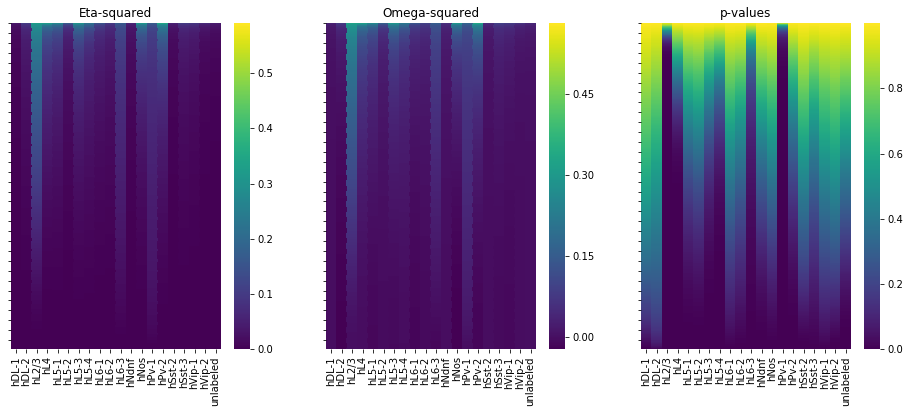

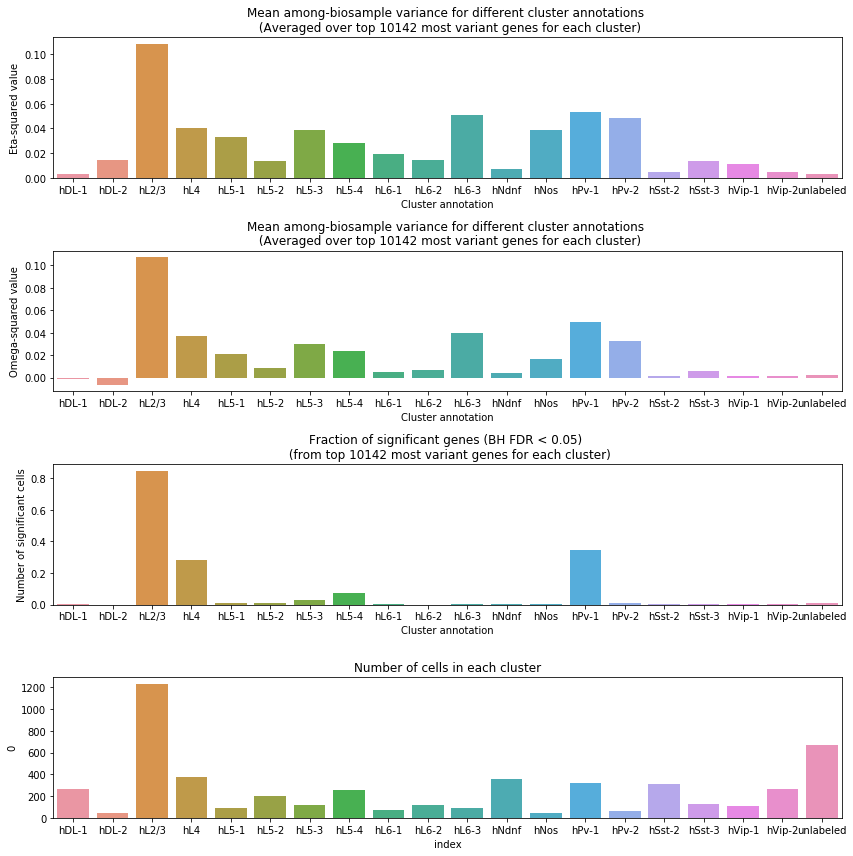

In [20]:
# eta-squared, omega-squared, and p-values 

df_res1 = df_eta
df_res2 = df_ome
df_res3 = df_p
n_top = df_res1.shape[0] 

df_res_ordered1 = order_df_res(df_res1)
df_res_ordered2 = order_df_res(df_res2)
df_res_ordered3 = order_df_res(df_res3)
    
df_plot1 = df_res_ordered1.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot1.reset_index(level=0, inplace=True)
df_plot1.columns = ['Cluster annotation', 'Eta-squared value']

df_plot2 = df_res_ordered2.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot2.reset_index(level=0, inplace=True)
df_plot2.columns = ['Cluster annotation', 'Omega-squared value']

# number of variant genes
df_plot3 = pd.Series()
for col in df_p.columns:
    rejs, *dis = multipletests(df_p[col], alpha=0.05, method='hs')
    df_plot3[col] = rejs.sum()
df_plot3 = (df_plot3/df_p.shape[0]).to_frame().reset_index()
df_plot3.columns = ['Cluster annotation', 'Number of significant cells']


fig, axs = plt.subplots(1, 3, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_res_ordered1.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Eta-squared')
ax.set_yticklabels([])
ax = axs[1]
sns.heatmap(df_res_ordered2.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Omega-squared')
ax.set_yticklabels([])
ax = axs[2]
sns.heatmap(df_res_ordered3.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('p-values')
ax.set_yticklabels([])
plt.show()

fig, axs = plt.subplots(4, 1, figsize=(12, 12))
ax = axs[0]
sns.barplot(x='Cluster annotation', y='Eta-squared value', data=df_plot1, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[1]
sns.barplot(x='Cluster annotation', y='Omega-squared value', data=df_plot2, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[2]
sns.barplot(x='Cluster annotation', y='Number of significant cells', data=df_plot3, ax=ax)
ax.set_title('Fraction of significant genes (BH FDR < 0.05) \n (from top %d most variant genes for each cluster)' % n_top)
ax = axs[3]
sns.barplot(x='index', y=0, data=sr_n.to_frame().reset_index(), ax=ax)
ax.set_title('Number of cells in each cluster')
fig.tight_layout()
plt.show()



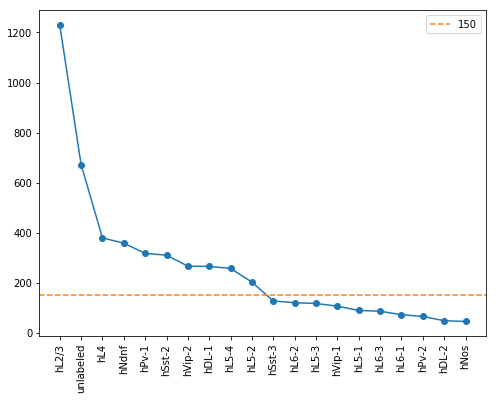

hDL-1         265
hL2/3        1230
hL4           379
hL5-2         202
hL5-4         257
hNdnf         358
hPv-1         317
hSst-2        310
hVip-2        266
unlabeled     672
dtype: int64

In [21]:
# number of cells in each cluster

sr_n_sorted = sr_n.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 6))
# sns.barplot(x='index', y=0, data=sr_n.sort_values(ascending=False).to_frame().reset_index(), ax=ax)
# ax.set_title('Number of cells in each cluster')

ax.plot(sr_n_sorted.values, '-o')
ax.set_xticklabels(sr_n_sorted.index.values, rotation=90)
ax.set_xticks([i for i in range(sr_n.shape[0])])
ax.axhline(y=150, ls='dashed', color='C1', label='150')
ax.legend()
plt.show()

sr_n_tr = sr_n.loc[sr_n.index.isin(sr_n_sorted[(sr_n_sorted > 150)].index)]
sr_n_tr

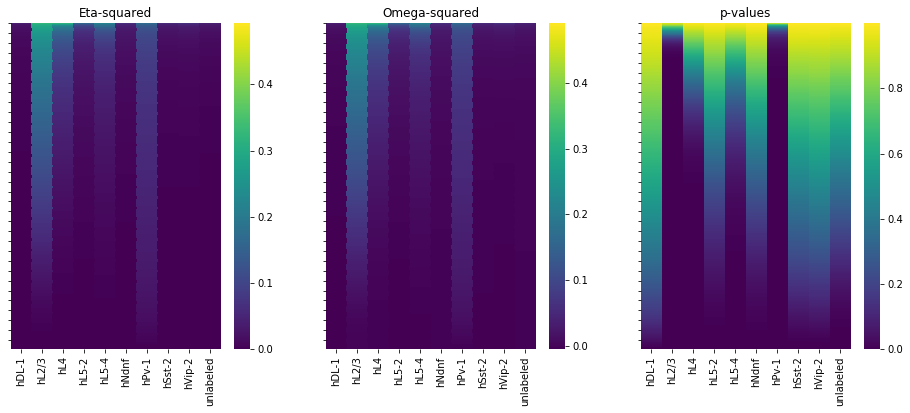

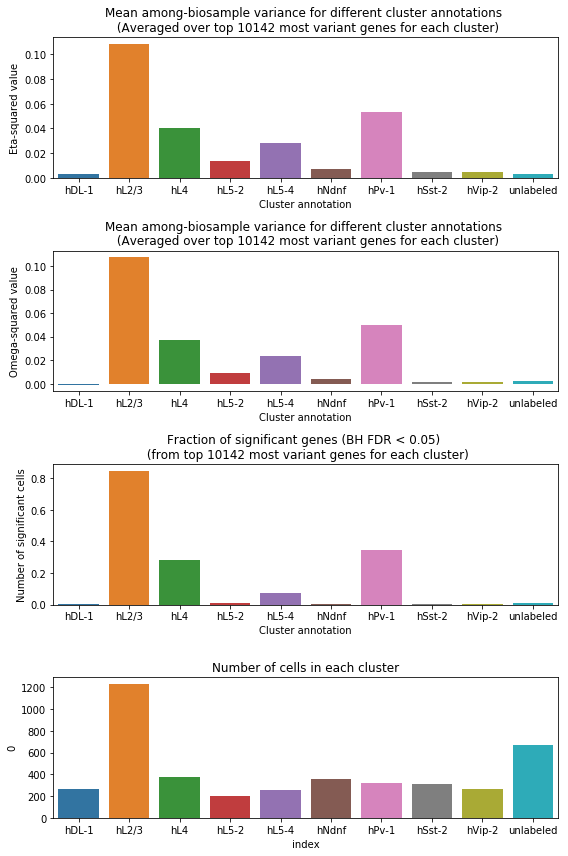

In [22]:
# rerun with truncated set of celltypes

# eta-squared, omega-squared, and p-values 

cell_types_tr = sr_n_tr.index.values  

df_res1 = df_eta[cell_types_tr]
df_res2 = df_ome[cell_types_tr]
df_res3 = df_p[cell_types_tr]
n_top = df_res1.shape[0] 

df_res_ordered1 = order_df_res(df_res1)
df_res_ordered2 = order_df_res(df_res2)
df_res_ordered3 = order_df_res(df_res3)
    
df_plot1 = df_res_ordered1.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot1.reset_index(level=0, inplace=True)
df_plot1.columns = ['Cluster annotation', 'Eta-squared value']

df_plot2 = df_res_ordered2.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot2.reset_index(level=0, inplace=True)
df_plot2.columns = ['Cluster annotation', 'Omega-squared value']

# number of variant genes
df_plot3 = pd.Series()
for col in df_res3.columns:
    rejs, *dis = multipletests(df_res3[col], alpha=0.05, method='hs')
    df_plot3[col] = rejs.sum()
df_plot3 = (df_plot3/df_p.shape[0]).to_frame().reset_index()
df_plot3.columns = ['Cluster annotation', 'Number of significant cells']


fig, axs = plt.subplots(1, 3, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_res_ordered1.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Eta-squared')
ax.set_yticklabels([])
ax = axs[1]
sns.heatmap(df_res_ordered2.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Omega-squared')
ax.set_yticklabels([])
ax = axs[2]
sns.heatmap(df_res_ordered3.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('p-values')
ax.set_yticklabels([])
plt.show()

fig, axs = plt.subplots(4, 1, figsize=(8, 12))
ax = axs[0]
sns.barplot(x='Cluster annotation', y='Eta-squared value', data=df_plot1, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[1]
sns.barplot(x='Cluster annotation', y='Omega-squared value', data=df_plot2, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[2]
sns.barplot(x='Cluster annotation', y='Number of significant cells', data=df_plot3, ax=ax)
ax.set_title('Fraction of significant genes (BH FDR < 0.05) \n (from top %d most variant genes for each cluster)' % n_top)
ax = axs[3]
sns.barplot(x='index', y=0, data=sr_n_tr.to_frame().reset_index(), ax=ax)
ax.set_title('Number of cells in each cluster')
fig.tight_layout()
plt.show()


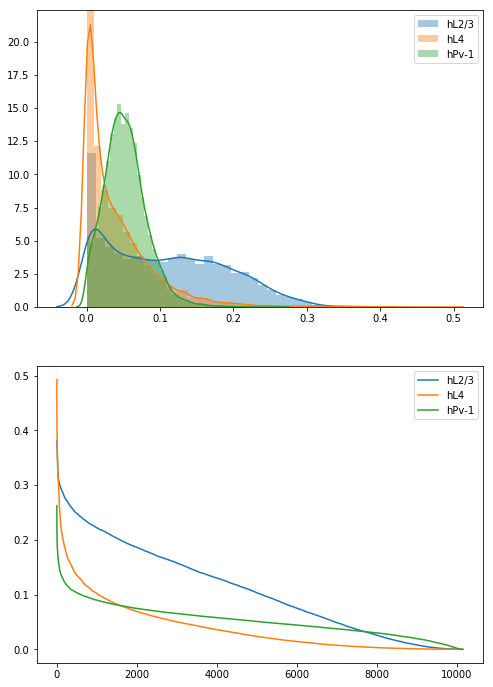

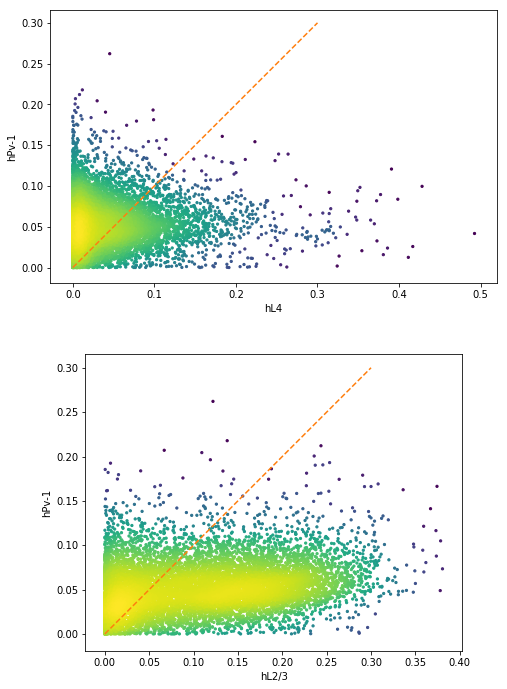

In [23]:
# eta-squared 
df_res = df_eta 
n_top = df_res.shape[0] 

df_res_ordered = pd.DataFrame()
for col in df_res.columns:
    df_res_ordered[col] = df_res[col].sort_values(ascending=False).values
    
fig, axs = plt.subplots(2, 1, figsize=(8, 12))
ax = axs[0]
sns.distplot(df_res['hL2/3'].values, ax=ax, label='hL2/3')
sns.distplot(df_res['hL4'].values, ax=ax, label='hL4')
# sns.distplot(df_res['hL5-2'].values, ax=ax, label='hL5-2')
sns.distplot(df_res['hPv-1'].values, ax=ax, label='hPv-1')
# sns.distplot(df_res['hNdnf'].values, ax=ax, label='hNdnf')
ax.legend()

ax = axs[1]
ax.plot(df_res_ordered['hL2/3'].values, label='hL2/3')
ax.plot(df_res_ordered['hL4'].values, label='hL4')
# ax.plot(df_res_ordered['hL5-2'].values, label='hL5-2')
ax.plot(df_res_ordered['hPv-1'].values, label='hPv-1')
# ax.plot(df_res_ordered['hNdnf'].values, label='hNdnf')
# ax.set_yscale('log')
ax.legend()
plt.show()


fig, axs = plt.subplots(2, 1, figsize=(8, 12))
ax = axs[0]
xy = np.vstack([df_res['hL4'].values, df_res['hPv-1'].values]) 
z = gaussian_kde(xy)(xy)
ax.scatter(df_res['hL4'].values, df_res['hPv-1'].values, c=np.log10(z), s=5)
ax.set_xlabel('hL4')
ax.set_ylabel('hPv-1')
line_x = np.arange(0, 0.4, 0.1)
line_y = np.arange(0, 0.4, 0.1)
ax.plot(line_x, line_y, '--', color='C1')
ax.set_aspect('equal')

ax = axs[1]
xy = np.vstack([df_res['hL2/3'].values, df_res['hPv-1'].values]) 
z = gaussian_kde(xy)(xy)
ax.scatter(df_res['hL2/3'].values, df_res['hPv-1'].values, c=np.log10(z), s=5)
ax.set_xlabel('hL2/3')
ax.set_ylabel('hPv-1')
line_x = np.arange(0, 0.4, 0.1)
line_y = np.arange(0, 0.4, 0.1)
ax.plot(line_x, line_y, '--', color='C1')
ax.set_aspect('equal')
plt.show()



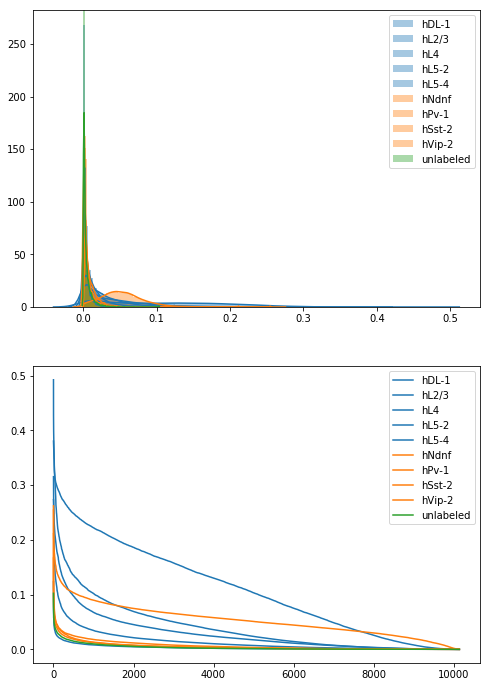

In [25]:
# eta-squared

# df_cell_class.loc[cell_types_tr].groupby('cell_class')


df_res = df_eta[cell_types_tr] 
n_top = df_res.shape[0] 

df_res_ordered = pd.DataFrame()
for col in df_res.columns:
    df_res_ordered[col] = df_res[col].sort_values(ascending=False).values
    
fig, axs = plt.subplots(2, 1, figsize=(8, 12))
ax = axs[0]
for col in df_res.columns:
    if df_cell_class.loc[col, 'cell_class'] == 'exci':
        sns.distplot(df_res[col].values, ax=ax, label=col, color='C0')
    elif df_cell_class.loc[col, 'cell_class'] == 'inhi':
        sns.distplot(df_res[col].values, ax=ax, label=col, color='C1')
    elif df_cell_class.loc[col, 'cell_class'] == 'glia':
        sns.distplot(df_res[col].values, ax=ax, label=col, color='C2')
ax.legend()

ax = axs[1]
for col in df_res.columns:
    if df_cell_class.loc[col, 'cell_class'] == 'exci':
        ax.plot(df_res_ordered[col].values, label=col, color='C0')
    elif df_cell_class.loc[col, 'cell_class'] == 'inhi':
        ax.plot(df_res_ordered[col].values, label=col, color='C1')
    elif df_cell_class.loc[col, 'cell_class'] == 'glia':
        ax.plot(df_res_ordered[col].values, label=col, color='C2')
ax.legend()
plt.show()



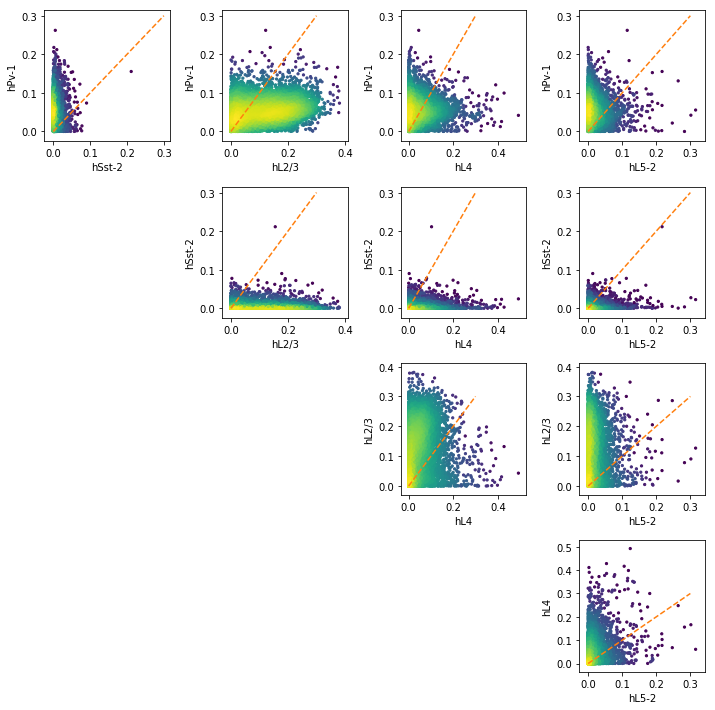

In [26]:
# hPv-1, hSst-2, hL2/3, hL4, hL5-2

cell_types_tr2 = ['hPv-1', 'hSst-2', 'hL2/3', 'hL4', 'hL5-2']
n = len(cell_types_tr2)

fig, axs = plt.subplots(n, n, figsize=(12, 12))
for i, j in zip(*np.tril_indices_from(axs, k=0)):
    axs[i, j].set_visible(False)
for i, j in zip(*np.triu_indices_from(axs, k=1)):
    ax = axs[i, j]
    cti = cell_types_tr2[j]
    ctj = cell_types_tr2[i]
    xy = np.vstack([df_res[cti].values, df_res[ctj].values]) 
    z = gaussian_kde(xy)(xy)
    ax.scatter(df_res[cti].values, df_res[ctj].values, c=np.log10(z), s=5)
    ax.set_xlabel(cti)
    ax.set_ylabel(ctj)
    line_x = np.arange(0, 0.4, 0.1)
    line_y = np.arange(0, 0.4, 0.1)
    ax.plot(line_x, line_y, '--', color='C1')
    ax.set_aspect('auto')
    
fig.tight_layout()
plt.show()



# Look at one cell type (hL4)

In [27]:
# repeat with different n 

# take top n genes for hL4

# classifier LDA   

# evaluate

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import metrics 
from sklearn.model_selection import KFold

# number of cells from each biosample

def get_data(celltype):
    cells = df_info[df_info.cluster_annotation==celltype].index.values
    cells_v1 = df_info[(df_info.cluster_annotation==celltype) & (df_info.Biosample=='MB_v1')].index.values
    cells_EA = df_info[(df_info.cluster_annotation==celltype) & (df_info.Biosample=='MB_EA')].index.values
    cells_EB = df_info[(df_info.cluster_annotation==celltype) & (df_info.Biosample=='MB_EB')].index.values
#     print(np.asarray([cells_v1.shape[0], cells_EA.shape[0], cells_EB.shape[0]])/cells.shape[0])

    # generate data
    cells = df_info[df_info['cluster_annotation']==celltype].index.values
    y = df_info.loc[cells, 'Biosample']
    X0 = df_mcc.loc[df_p.sample(frac=1).index.values, cells+'_mcc'].T 
    X0.index = [cell[:-len('_mcc')] for cell in X0.index]
    X1 = df_mcc.loc[df_p[celltype].sort_values().index.values, cells+'_mcc'].T 
    X1.index = [cell[:-len('_mcc')] for cell in X1.index]
    df_xy0 = pd.merge(X0, y.to_frame(), left_index=True, right_index=True)
    df_xy1 = pd.merge(X1, y.to_frame(), left_index=True, right_index=True)
#     print(df_xy0.shape)
#     print(df_xy1.shape)
    return df_xy0, df_xy1
    

In [28]:

def LDA_xvalid(df_xy, n_splits=5):
    """
    X = regex="^ENSG"
    y = "Biosample"
    
    """
    # 5-fold cv with LDA
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    # n_tops = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
    n_tops = np.arange(1, 100, 2)
    # n_tops = np.arange(1, 100, 5)

    mean_accs = []
    mean_f1_micros = []
    mean_f1_macros = []
    split_scheme = list(kf.split(df_xy))
    for n_top in n_tops:
        accs = []
        f1_micros = []
        f1_macros = []
        for i, (train_index, test_index) in enumerate(split_scheme):
            X_train = df_xy.iloc[train_index, :n_top].filter(regex='^ENSG')
            X_test = df_xy.iloc[test_index, :n_top].filter(regex='^ENSG')
            y_train = df_xy.iloc[train_index, :].Biosample
            y_test = df_xy.iloc[test_index, :].Biosample

            # train LDA model
            lda = LDA().fit(X_train, y_train)
            y_pred = lda.predict(X_test)

            # evaluate
            acc = metrics.accuracy_score(y_test, y_pred)
            f1_micro = metrics.f1_score(y_test, y_pred, average='micro')
            f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
            accs.append(acc)
            f1_micros.append(f1_micro)
            f1_macros.append(f1_macro)

    #         if i == 0:
    #             conf_mat = metrics.confusion_matrix(y_test, y_pred)
    #             print(conf_mat)


        mean_acc = np.mean(accs)
        mean_f1_micro = np.mean(f1_micros)
        mean_f1_macro = np.mean(f1_macros)

        mean_accs.append(mean_acc)
        mean_f1_micros.append(mean_f1_micro)
        mean_f1_macros.append(mean_f1_macro)

    return mean_accs, mean_f1_micros, mean_f1_macros


/cndd/fangming/venvs/venv_dobro_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


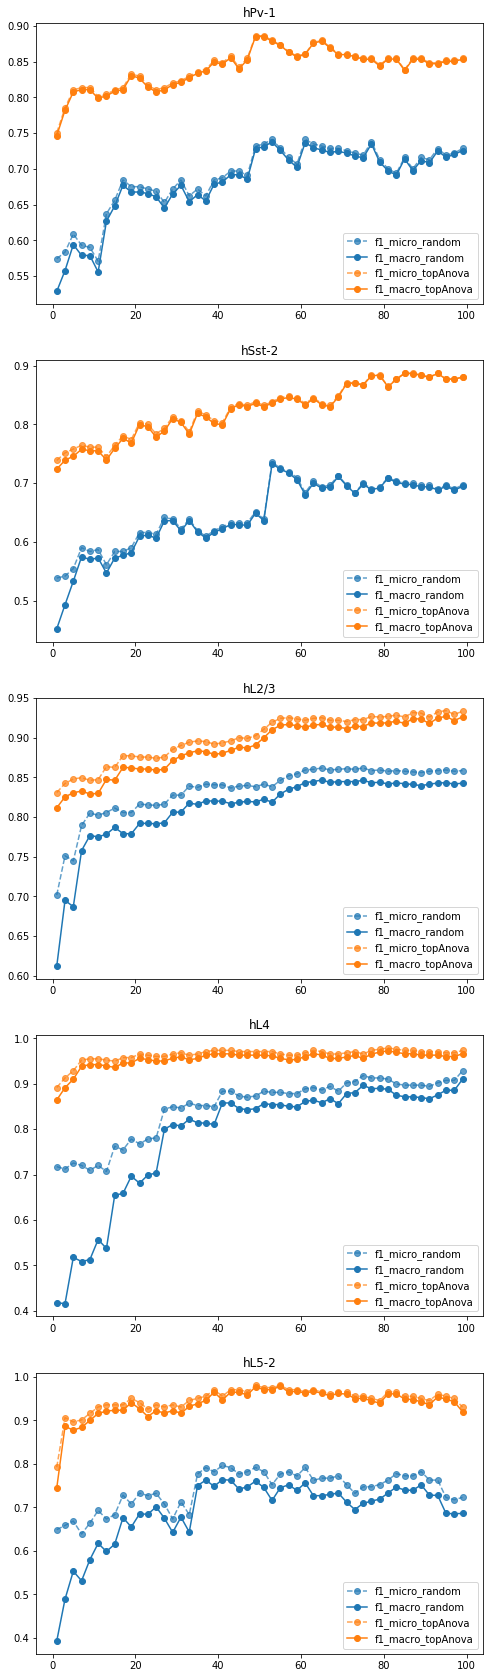

In [30]:
cell_types_tr2 = ['hPv-1', 'hSst-2', 'hL2/3', 'hL4', 'hL5-2']
n = len(cell_types_tr2)
n_tops = np.arange(1, 100, 2)

fig, axs = plt.subplots(n, 1, figsize=(8, 6*n))
for celltype, ax in zip(cell_types_tr2, axs):
    
    df_xy0, df_xy1 = get_data(celltype)
    accs0, f1_micros0, f1_macros0 = LDA_xvalid(df_xy0)
    accs1, f1_micros1, f1_macros1 = LDA_xvalid(df_xy1)

    ax.plot(n_tops, f1_micros0, '--o', label='f1_micro_random', color='C0', alpha=0.7)
    ax.plot(n_tops, f1_macros0, '-o', label='f1_macro_random', color='C0')
    ax.plot(n_tops, f1_micros1, '--o', label='f1_micro_topAnova', color='C1', alpha=0.7)
    ax.plot(n_tops, f1_macros1, '-o', label='f1_macro_topAnova', color='C1')
    ax.set_title(celltype)
    ax.legend()
plt.show()

In [407]:
# What are the top 30 genes?
n_top = 30
sr_top_genes = df_gene.loc[df_p.hL4.sort_values().index.values[:n_top], 'geneName']
sr_top_genes.to_frame()

geneName
geneID                           
ENSG00000188641.8            DPYD
ENSG00000103528.12          SYT17
ENSG00000189319.9          FAM53B
ENSG00000258539.1    RP11-12J10.3
ENSG00000167281.14         RBFOX3
ENSG00000232878.1        DPYD-AS1
ENSG00000042832.7              TG
ENSG00000152578.8           GRIA4
ENSG00000170153.6          RNF150
ENSG00000117598.7           LPPR5
ENSG00000182329.6      AC079354.1
ENSG00000214357.4         NEURL1B
ENSG00000081248.6         CACNA1S
ENSG00000145808.4        ADAMTS19
ENSG00000251680.1     CTC-575N7.1
ENSG00000163638.9         ADAMTS9
ENSG00000166510.9          CCDC68
ENSG00000113319.7         RASGRF2
ENSG00000144868.9         TMEM108
ENSG00000241684.1     ADAMTS9-AS2
ENSG00000156218.8        ADAMTSL3
ENSG00000185513.10        L3MBTL1
ENSG00000068781.16  STON1-GTF2A1L
ENSG00000154654.10          NCAM2
ENSG00000172985.8          SH3RF3
ENSG00000133195.7        SLC39A11
ENSG00000188580.9          NKAIN2
ENSG00000206579.7            XKR4
ENSG00000273079.1          GRIN2B
ENSG00000005108.11         THSD7A

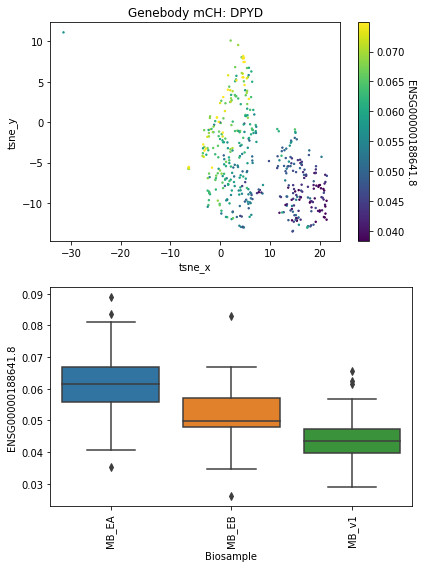

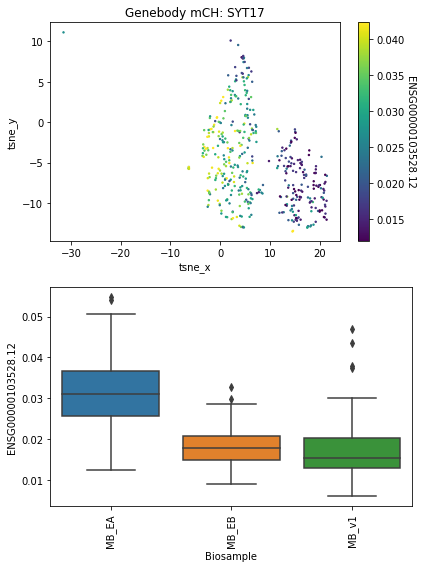

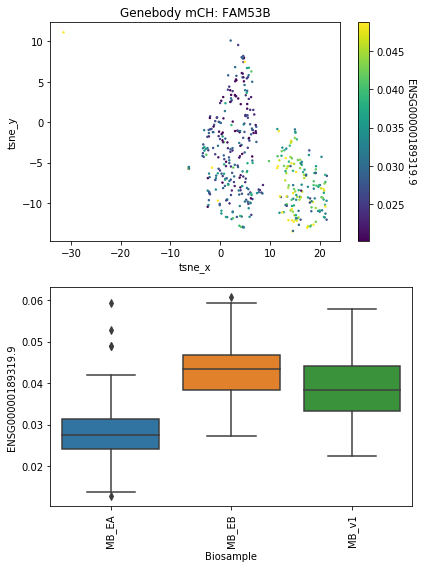

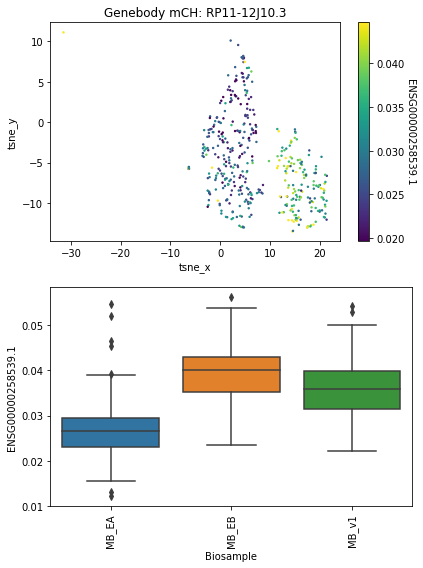

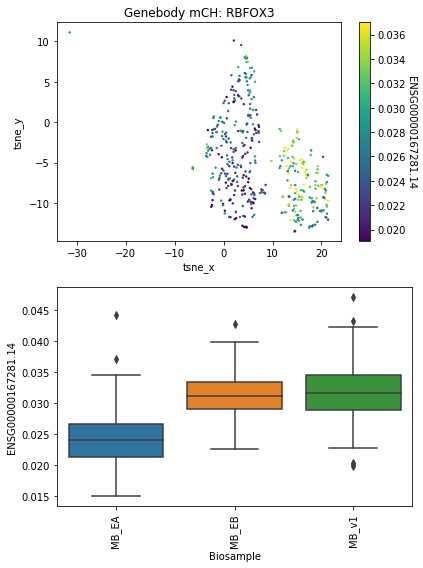

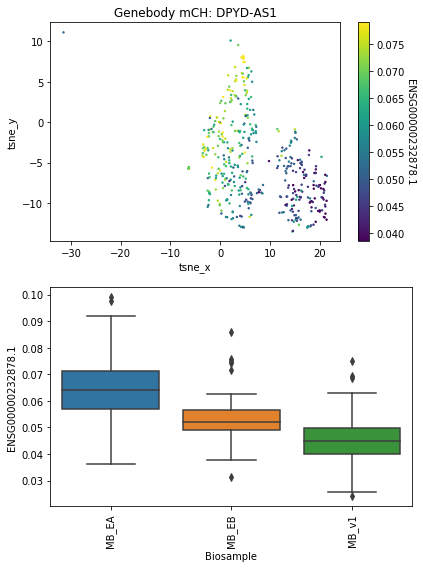

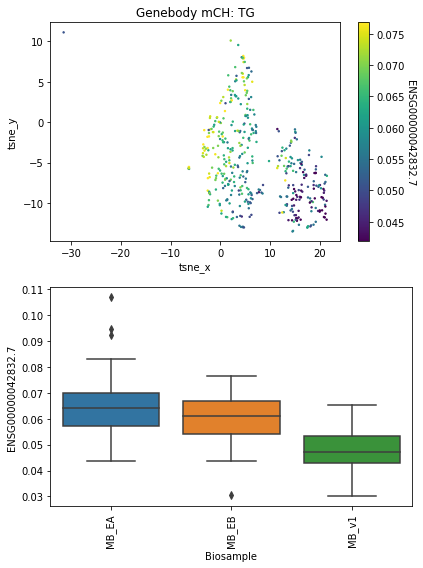

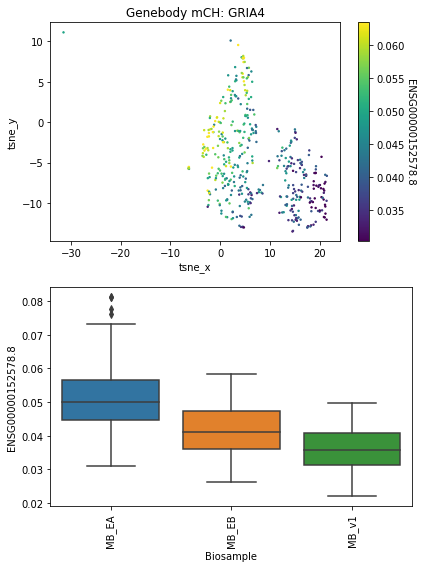

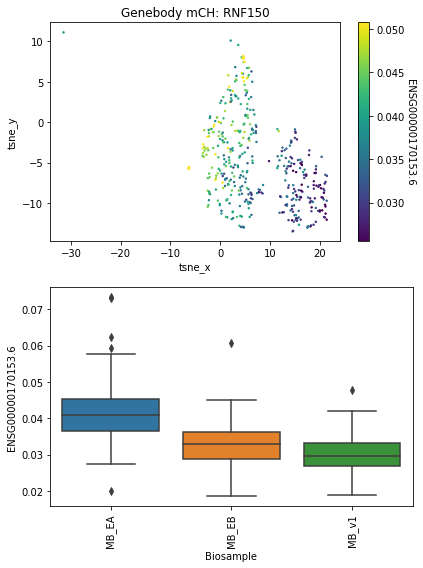

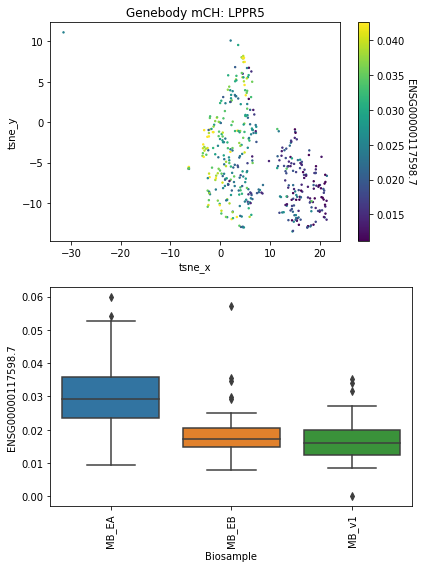

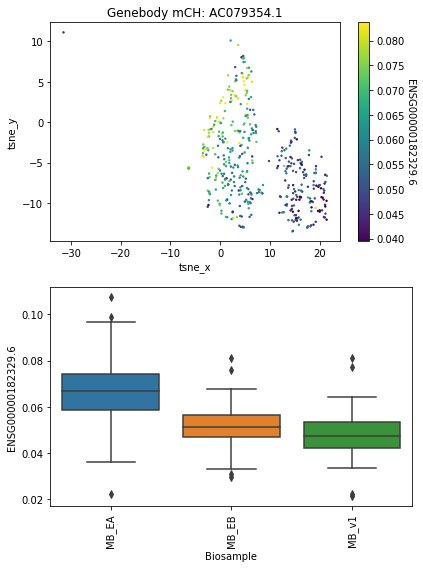

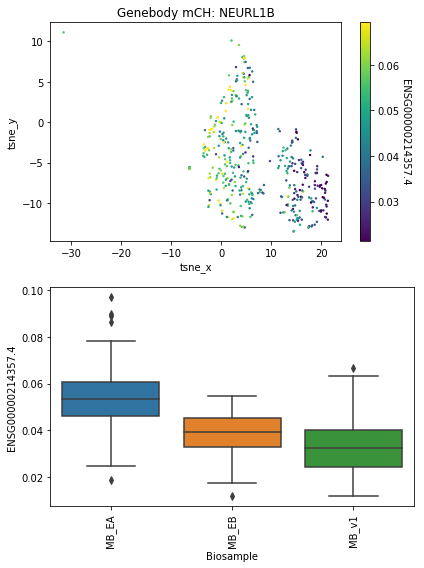

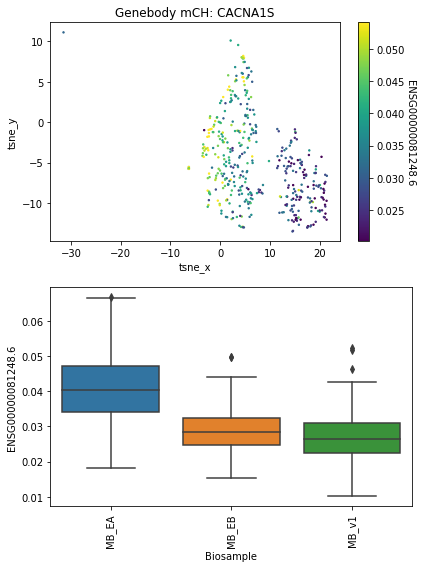

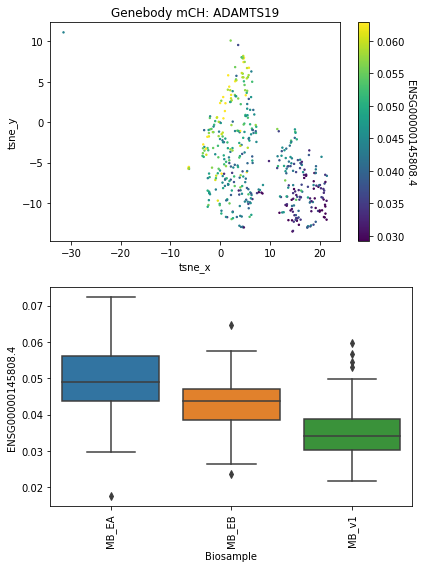

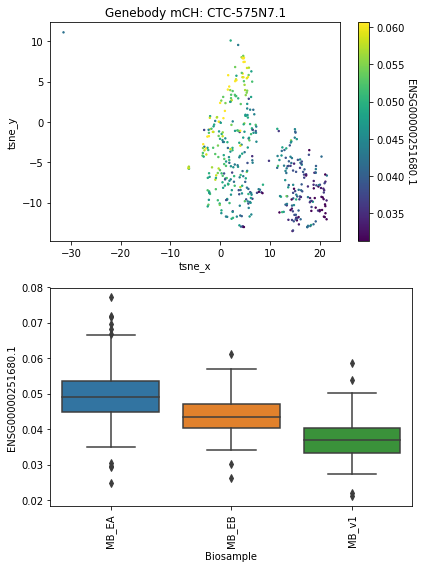

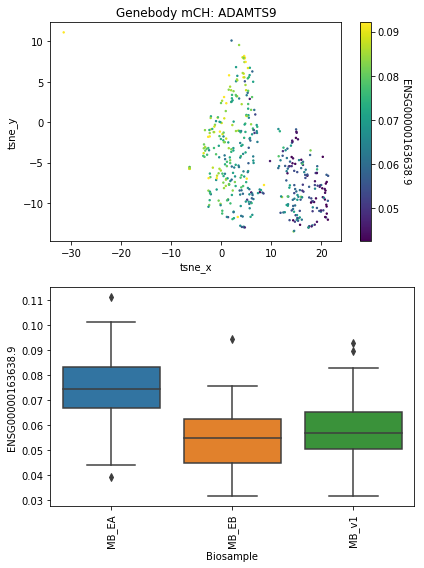

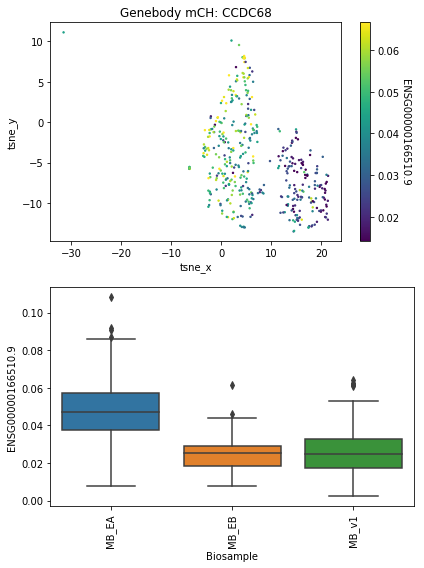

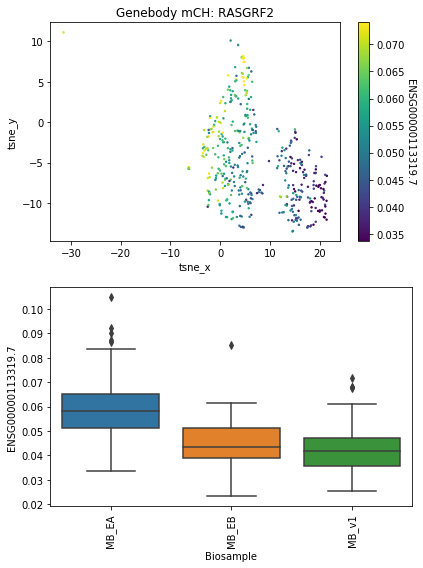

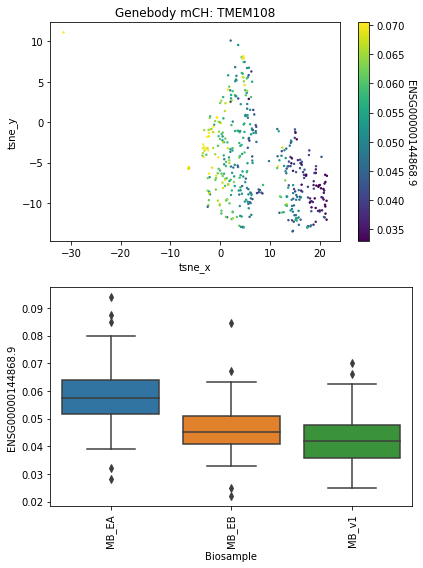

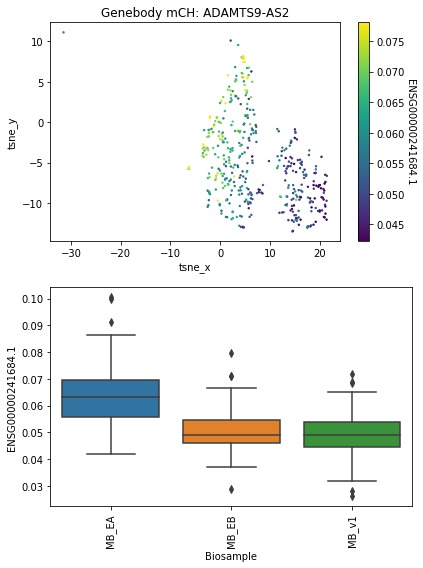

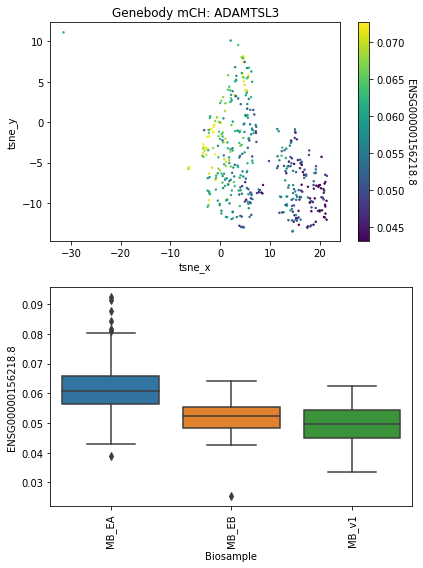

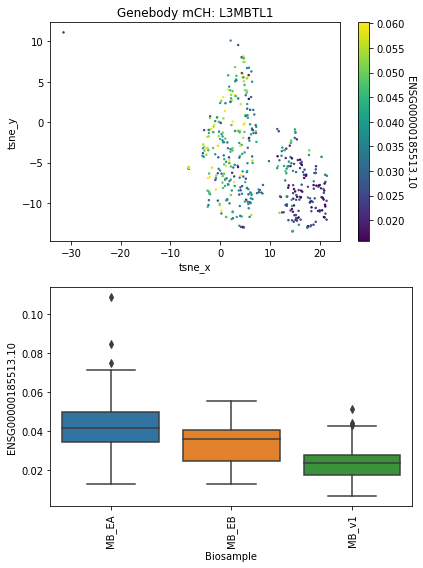

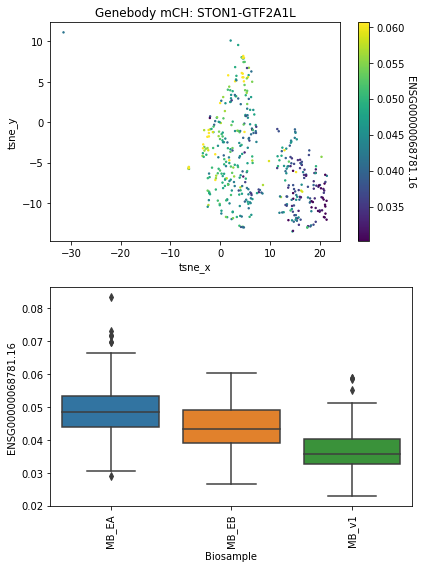

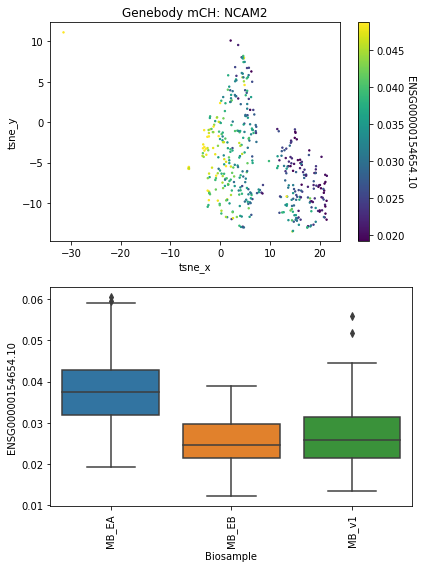

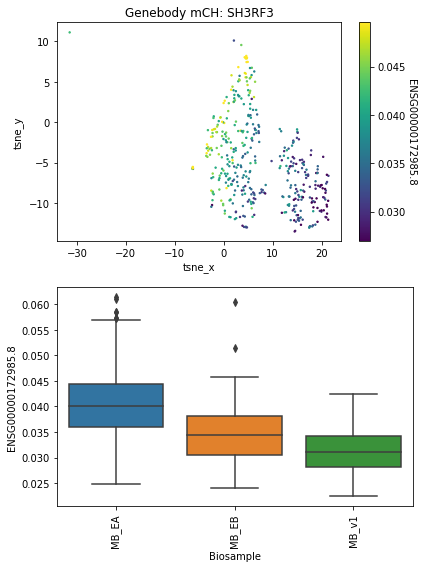

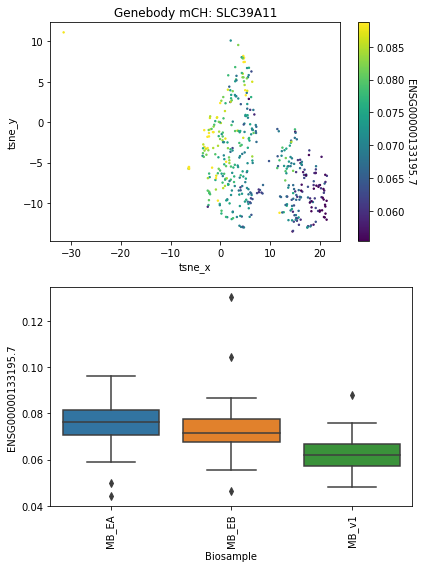

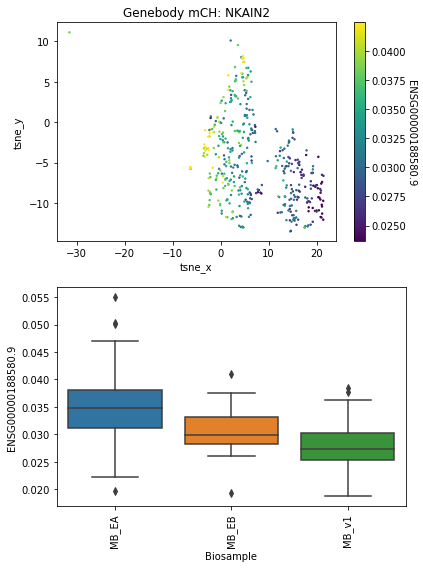

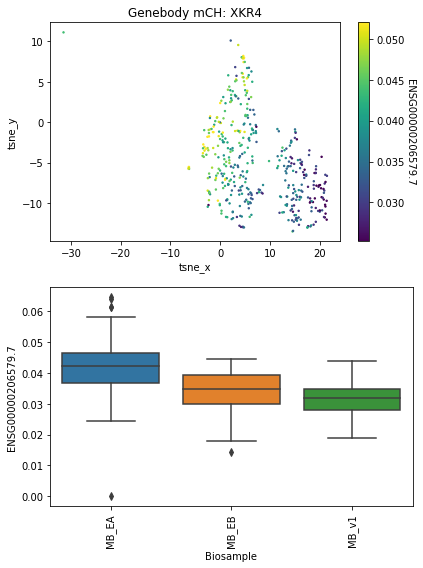

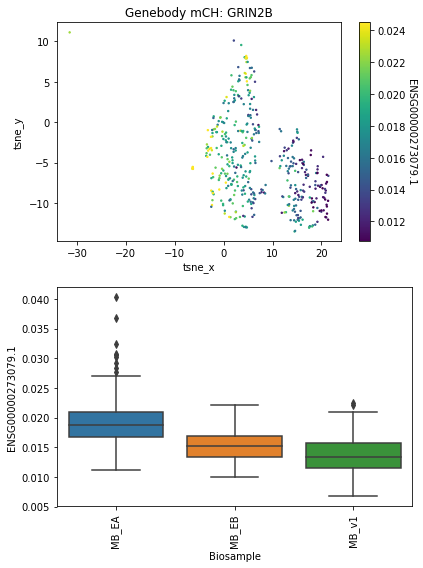

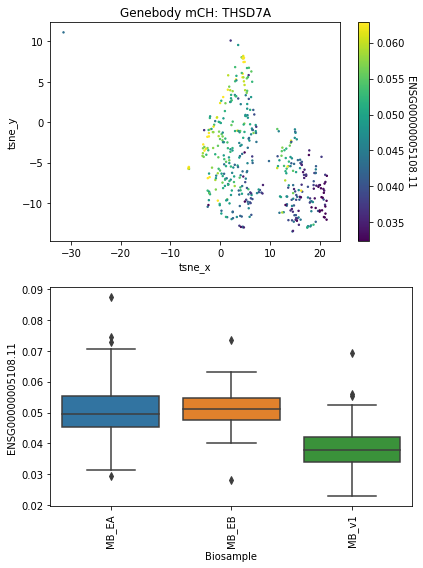

In [371]:
# Look at those genes in detail
# tsne and boxplot


for gene_id, gene_name in sr_top_genes.iteritems():
    df_plot = pd.merge(df_info, df_xy[[gene_id]], left_index=True, right_index=True) 
    tsne_and_boxplot(df_plot, tc=gene_id, bx='Biosample', by=gene_id,
                    output=None, show=True, close=False, 
                    title=('Genebody mCH: %s' % gene_name), 
                    figsize=(6,8),
                    t_xlim=None, t_ylim=None, b_xlim=None, b_ylim=None, 
                    low_p=5, hi_p=95)


# ICA marker genes (see if the lists converge)

1. run PCA, reduce dimensions of feature space (genes)

2. run ICA in PC spaces

3. identify certain interesting ICs
    - plot ICs against each other

    - plot IC on tSNE

4. Plot IC coefficients, look at top genes



In [375]:
df_x = df_xy.filter(regex='^ENSG')
print(df_x.shape)
df_x.head()


(429, 10142)


ENSG00000188641.8  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed           0.054693   
170508_MB_EA_hs_58yr_BA10_pool_1877_AD002_indexed           0.063727   
170508_MB_EA_hs_58yr_BA10_pool_1879_AD008_indexed           0.080225   
170508_MB_EA_hs_58yr_BA10_pool_1880_AD002_indexed           0.065077   
170508_MB_EA_hs_58yr_BA10_pool_1882_AD006_indexed           0.067083   

                                                   ENSG00000103528.12  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed            0.027683   
170508_MB_EA_hs_58yr_BA10_pool_1877_AD002_indexed            0.035971   
170508_MB_EA_hs_58yr_BA10_pool_1879_AD008_indexed            0.037559   
170508_MB_EA_hs_58yr_BA10_pool_1880_AD002_indexed            0.023792   
170508_MB_EA_hs_58yr_BA10_pool_1882_AD006_indexed            0.036220   

                                                   ENSG00000189319.9  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed           0.041071   
170508_MB_EA_hs_58yr_BA10_pool_1877_AD002_indexed           0.025052   
170508_MB_EA_hs_58yr_BA10_pool_1879_AD008_indexed           0.029478   
170508_MB_EA_hs_58yr_BA10_pool_1880_AD002_indexed           0.028777   
170508_MB_EA_hs_58yr_BA10_pool_1882_AD006_indexed           0.030876   

                                                   ENSG00000258539.1  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed           0.037724   
170508_MB_EA_hs_58yr_BA10_pool_1877_AD002_indexed           0.024326   
170508_MB_EA_hs_58yr_BA10_pool_1879_AD008_indexed           0.026829   
170508_MB_EA_hs_58yr_BA10_pool_1880_AD002_indexed           0.027835   
170508_MB_EA_hs_58yr_BA10_pool_1882_AD006_indexed           0.030507   

                                                   ENSG00000167281.14  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed            0.023166   
170508_MB_EA_hs_58yr_BA10_pool_1877_AD002_indexed            0.018769   
170508_MB_EA_hs_58yr_BA10_pool_1879_AD008_indexed            0.025731   
170508_MB_EA_hs_58yr_BA10_pool_1880_AD002_indexed            0.024185   
170508_MB_EA_hs_58yr_BA10_pool_1882_AD006_indexed            0.027951   

                                                   ENSG00000232878.1  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed           0.059208   
170508_MB_EA_hs_58yr_BA10_pool_1877_AD002_indexed           0.063758   
170508_MB_EA_hs_58yr_BA10_pool_1879_AD008_indexed           0.082348   
170508_MB_EA_hs_58yr_BA10_pool_1880_AD002_indexed           0.071757   
170508_MB_EA_hs_58yr_BA10_pool_1882_AD006_indexed           0.062427   

                                                   ENSG00000042832.7  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed           0.056272   
170508_MB_EA_hs_58yr_BA10_pool_1877_AD002_indexed           0.063198   
170508_MB_EA_hs_58yr_BA10_pool_1879_AD008_indexed           0.094547   
170508_MB_EA_hs_58yr_BA10_pool_1880_AD002_indexed           0.052857   
170508_MB_EA_hs_58yr_BA10_pool_1882_AD006_indexed           0.066599   

                                                   ENSG00000152578.8  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed           0.047310   
170508_MB_EA_hs_58yr_BA10_pool_1877_AD002_indexed           0.058743   
170508_MB_EA_hs_58yr_BA10_pool_1879_AD008_indexed           0.061094   
170508_MB_EA_hs_58yr_BA10_pool_1880_AD002_indexed           0.044118   
170508_MB_EA_hs_58yr_BA10_pool_1882_AD006_indexed           0.055370   

                                                   ENSG00000170153.6  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed           0.036506   
170508_MB_EA_hs_58yr_BA10_pool_1877_AD002_indexed           0.050000   
170508_MB_EA_hs_58yr_BA10_pool_1879_AD008_indexed           0.049860   
170508_MB_EA_hs_58yr_BA10_pool_1880_AD002_indexed           0.047567   
170508_MB_EA_hs_58yr_BA10_pool_1882_AD006_indexed           0.046061   

                                                   ENSG00000117598.7  \
170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed           0.029106  

In [379]:
# ICA workflow


n_comp = 10
# fit PCA
pca = PCA(n_components=n_comp).fit(df_x)
pcs = pca.transform(df_x)

df_pc_axis = pd.DataFrame(pca.components_, 
                       index=['PC' + str(i+1) for i in range(n_comp)], 
                       columns=df_x.columns)

df_pc_axis.head()


ENSG00000188641.8  ENSG00000103528.12  ENSG00000189319.9  \
PC1           0.016373            0.007148          -0.001946   
PC2          -0.034228           -0.040222           0.037825   
PC3          -0.008520            0.021444           0.019027   
PC4          -0.006182           -0.003525           0.005742   
PC5           0.016720            0.015510          -0.022165   

     ENSG00000258539.1  ENSG00000167281.14  ENSG00000232878.1  \
PC1          -0.001011            0.001906           0.017593   
PC2           0.032559            0.027986          -0.037205   
PC3           0.016964           -0.000395          -0.009739   
PC4           0.003988            0.006918          -0.008367   
PC5          -0.020146           -0.013717           0.028737   

     ENSG00000042832.7  ENSG00000152578.8  ENSG00000170153.6  \
PC1           0.015193           0.016148           0.011482   
PC2          -0.027853          -0.028998          -0.020622   
PC3           0.006557           0.005543           0.004115   
PC4           0.005084          -0.002634          -0.012958   
PC5           0.002900           0.003365           0.020704   

     ENSG00000117598.7        ...          ENSG00000164190.12  \
PC1           0.011349        ...                    0.006240   
PC2          -0.032102        ...                    0.011243   
PC3           0.006389        ...                    0.006524   
PC4          -0.012024        ...                   -0.006644   
PC5           0.006562        ...                   -0.003411   

     ENSG00000174453.5  ENSG00000114812.8  ENSG00000127191.13  \
PC1           0.002119           0.001894            0.006750   
PC2           0.002535           0.006373            0.009575   
PC3           0.004042           0.001195            0.001028   
PC4          -0.005883          -0.005739           -0.012187   
PC5          -0.000626           0.003868            0.010578   

     ENSG00000119599.12  ENSG00000050730.11  ENSG00000177951.13  \
PC1            0.003513            0.011863            0.004321   
PC2            0.004295            0.005577            0.009206   
PC3            0.014889            0.002047            0.007375   
PC4           -0.008866            0.002467           -0.005271   
PC5           -0.004066           -0.009402            0.000778   

     ENSG00000047365.7  ENSG00000166135.9  ENSG00000141646.9  
PC1           0.005282           0.005361           0.005588  
PC2           0.007295           0.008005           0.007826  
PC3           0.004521           0.004614           0.002226  
PC4          -0.009560          -0.001944           0.000307  
PC5          -0.004462          -0.001795          -0.003528  

[5 rows x 10142 columns]

In [389]:
# visualize PCA
# np.cov(pcs.T)
# np.diag(np.cov(pcs.T).diagonal())



In [392]:
# ICA after PCA and reconstruct data
# manual whitening
C = np.sqrt(np.diag(np.cov(pcs.T).diagonal()))
pcsw = np.dot(pcs, np.linalg.inv(C))
# check if whitened
# print(np.cov(pcsw.T))

# fit ICA
ica = FastICA(whiten=False).fit(pcsw)
ics = ica.transform(pcsw)
df_ics = pd.DataFrame(ics, columns=['IC'+str(i+1) for i in range(n_comp)], index=df_x.index)

axis = np.dot(np.dot(ica.components_, C), pca.components_)
df_ic_axis = pd.DataFrame(axis, 
                       index=['IC' + str(i+1) for i in range(n_comp)], 
                       columns=df_x.columns)

(429, 31)


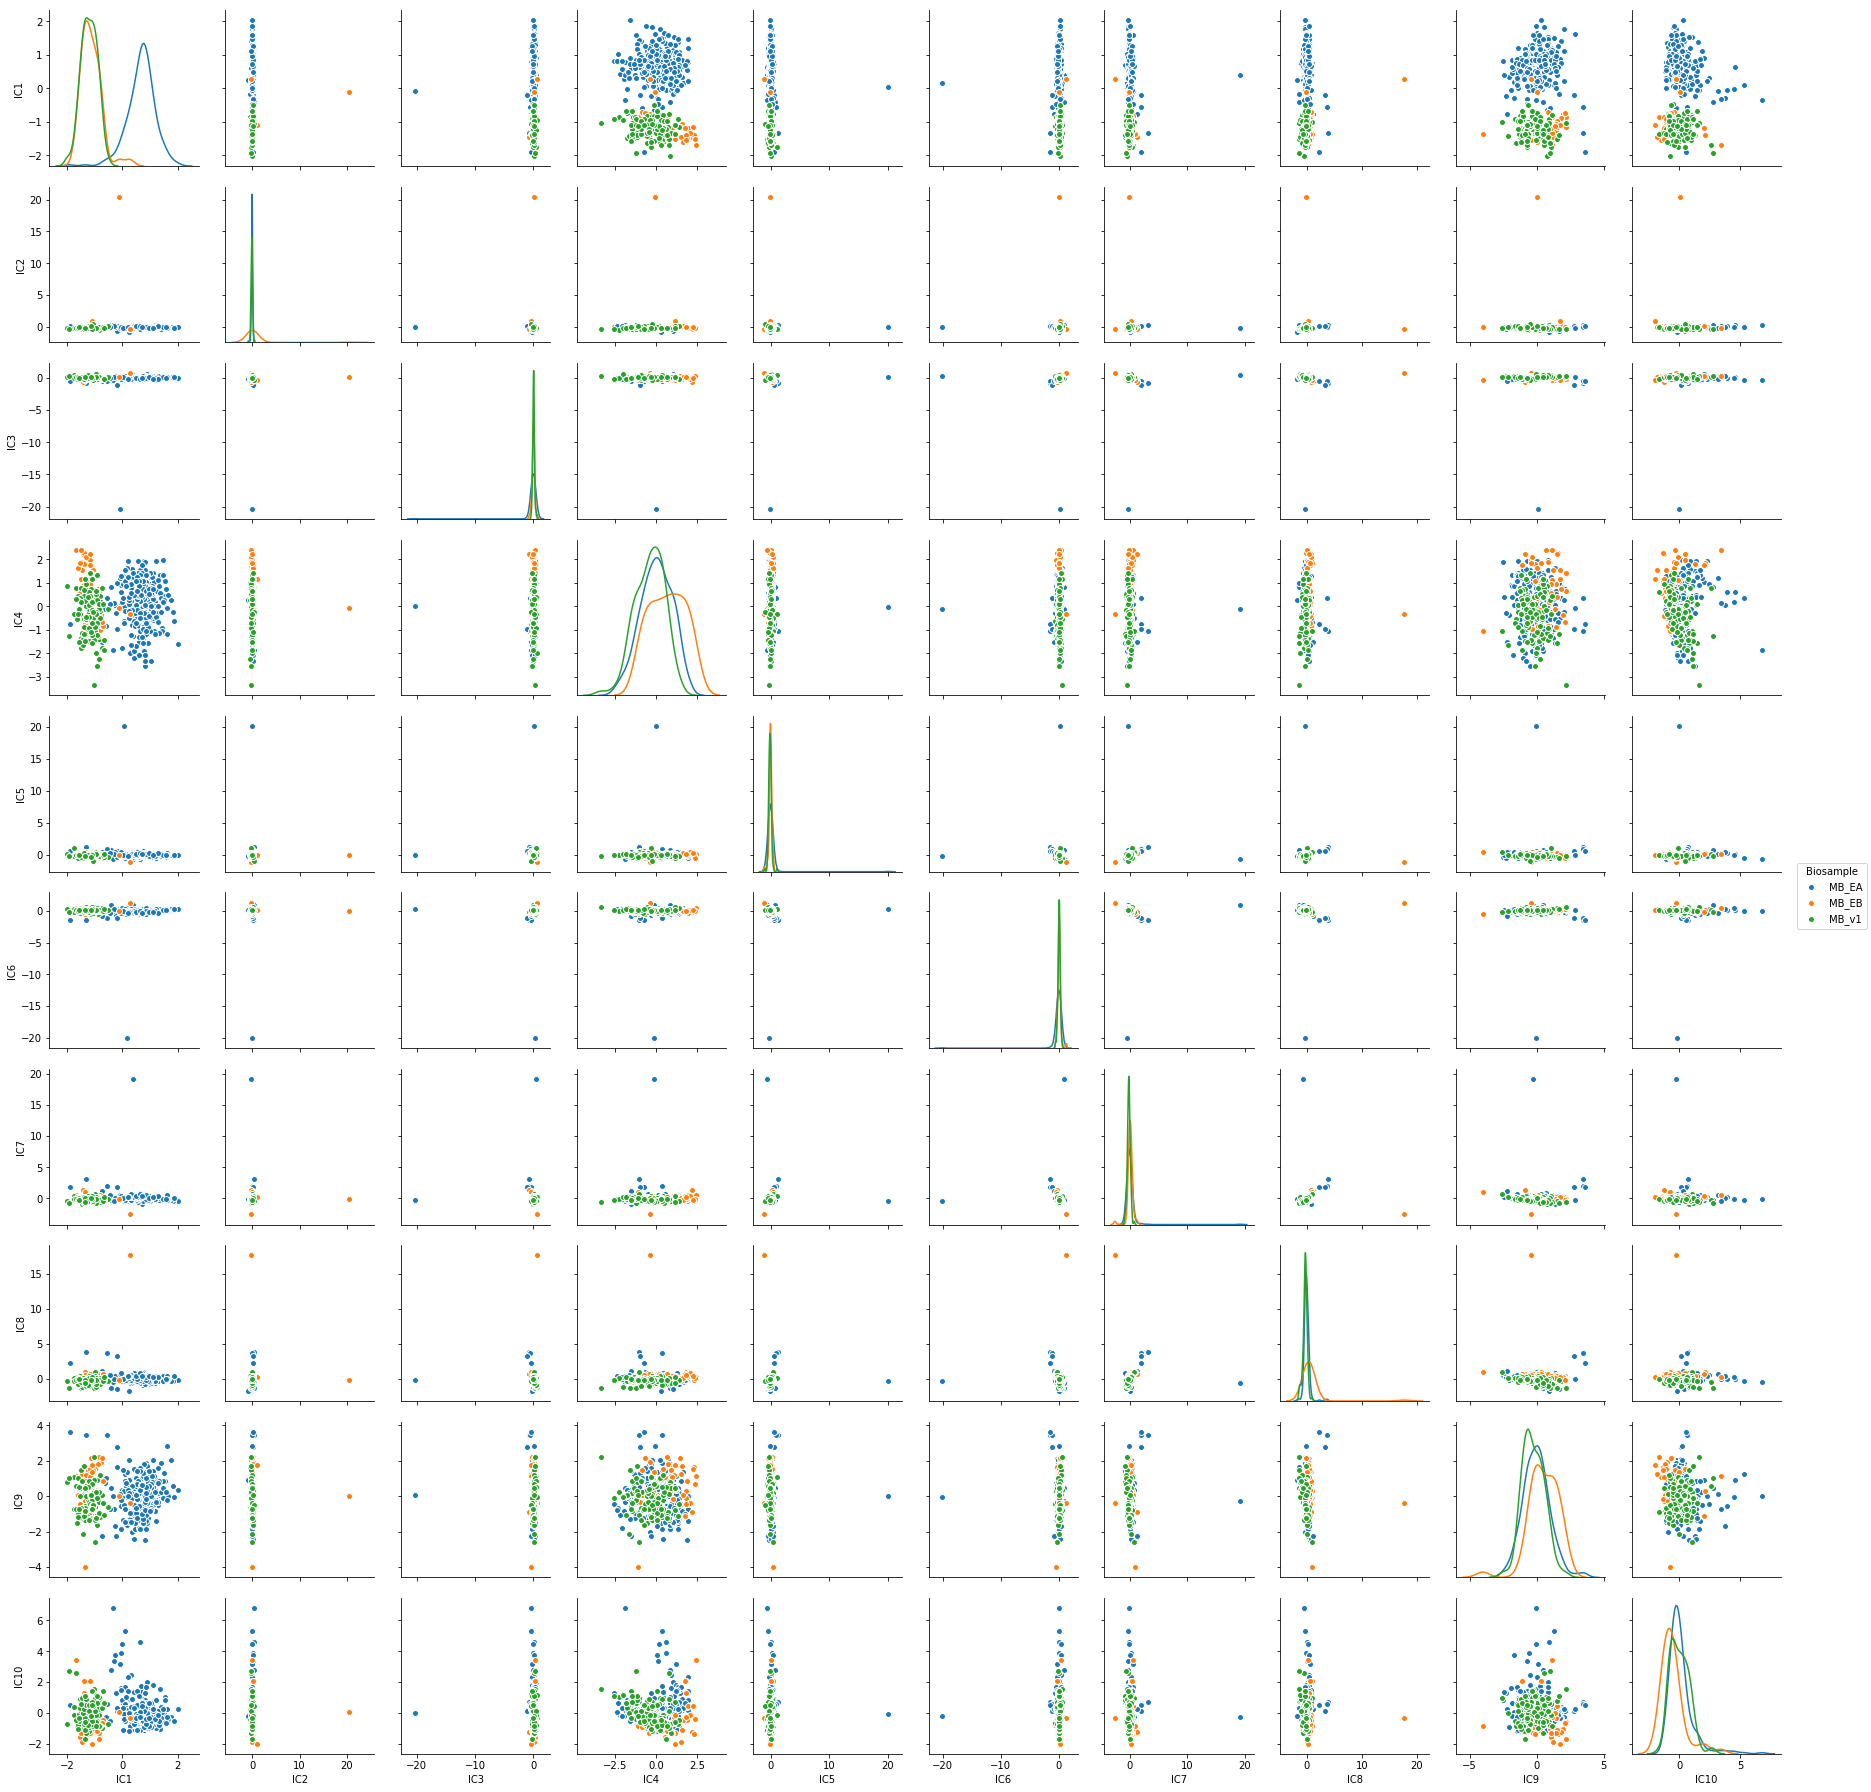

In [395]:
# plot ICs

df_plot_ics = pd.merge(df_ics, df_info, left_index=True, right_index=True)
print(df_plot_ics.shape)

g = sns.pairplot(df_plot_ics[df_ics.columns.tolist() + ['Biosample']], hue='Biosample', 
                 diag_kind='kde', markers='o', size=2.5)
# print(g.axes.shape)
# for i, j in zip(*np.triu_indices_from(g.axes, k=1)):
#     g.axes[i, j].set_visible(False)
plt.show()

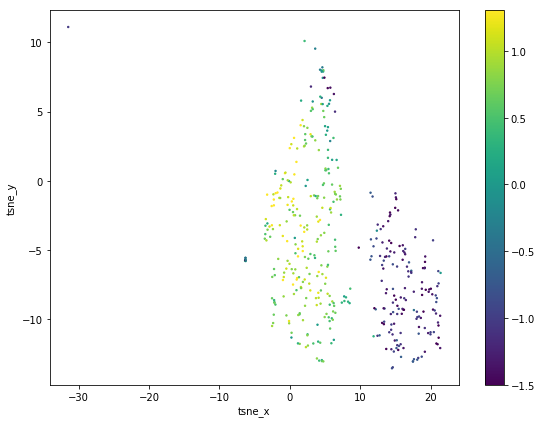

In [398]:
# plot IC tsne
plot_tsne_values(df_plot_ics, tc='IC1')

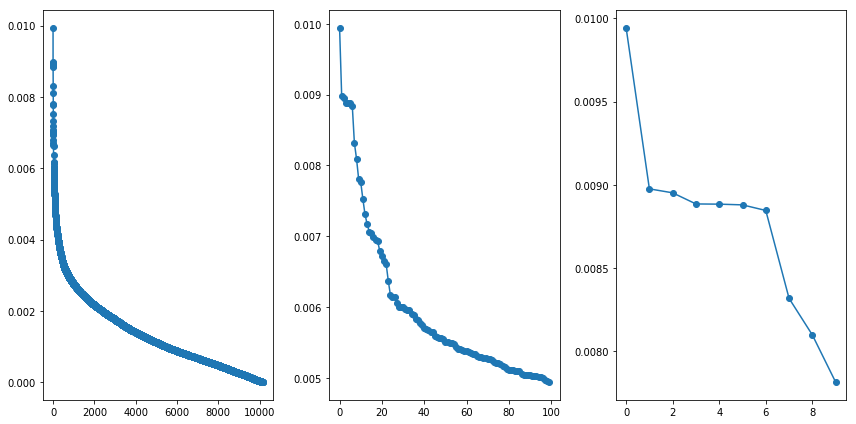

In [400]:
# 
# look at IC1 (which seperates MB_EA from other biosamples)

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
icc = df_ic_axis.loc['IC1', :].apply(np.abs).sort_values(ascending=False)
ax = axs[0]
ax.plot(icc.values, 'o-')
ax = axs[1]
ax.plot(icc.values[:100], 'o-')
ax = axs[2]
ax.plot(icc.values[:10], 'o-')
fig.tight_layout()
plt.show()

In [406]:
# what are those genes
n_top = 30
sr_top_genes_2 = df_gene.loc[icc.index.values[:n_top], 'geneName']
sr_top_genes_2.to_frame()

geneName
geneID                        
ENSG00000166510.9       CCDC68
ENSG00000162437.10      RAVER2
ENSG00000050165.13        DKK3
ENSG00000162769.8       FLVCR1
ENSG00000143479.11       DYRK3
ENSG00000214357.4      NEURL1B
ENSG00000104419.10       NDRG1
ENSG00000163638.9      ADAMTS9
ENSG00000136371.5        MTHFS
ENSG00000182329.6   AC079354.1
ENSG00000232878.1     DPYD-AS1
ENSG00000171631.10       P2RY6
ENSG00000185513.10     L3MBTL1
ENSG00000103528.12       SYT17
ENSG00000188641.8         DPYD
ENSG00000139263.7        LRIG3
ENSG00000155926.9          SLA
ENSG00000179796.7       LRRC3B
ENSG00000113319.7      RASGRF2
ENSG00000144868.9      TMEM108
ENSG00000215475.3        SIAH3
ENSG00000103876.7          FAH
ENSG00000169330.4     KIAA1024
ENSG00000135272.5        MDFIC
ENSG00000111696.7       NT5DC3
ENSG00000152578.8        GRIA4
ENSG00000174705.7     SH3PXD2B
ENSG00000163932.9        PRKCD
ENSG00000114790.8     ARHGEF26
ENSG00000042832.7           TG

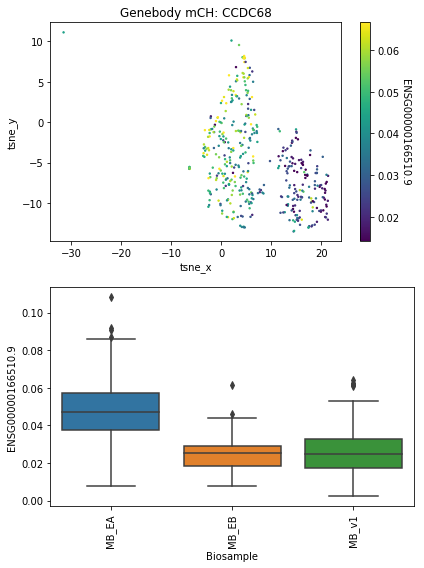

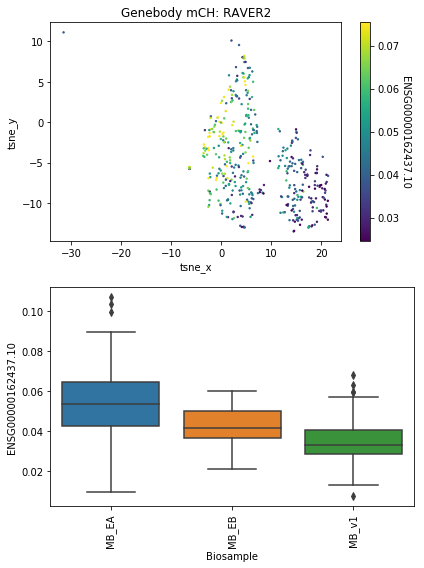

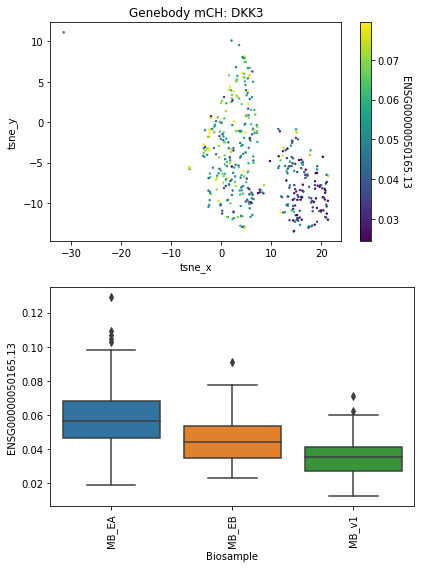

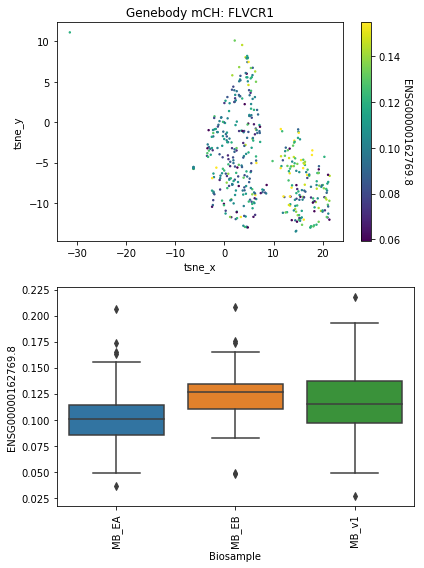

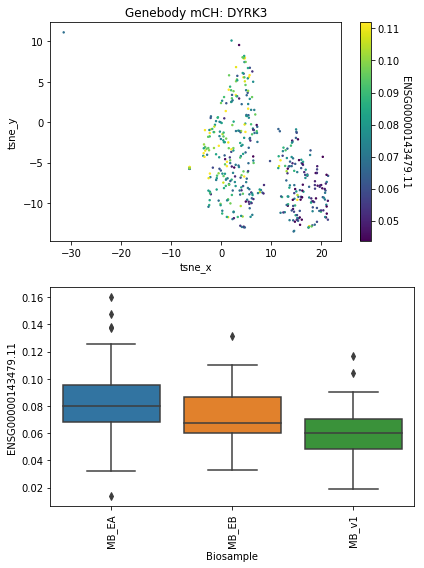

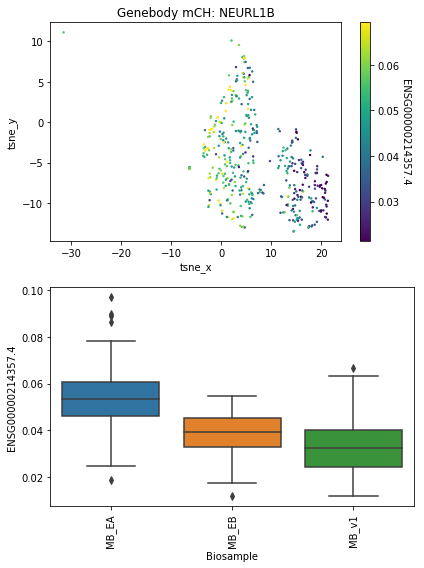

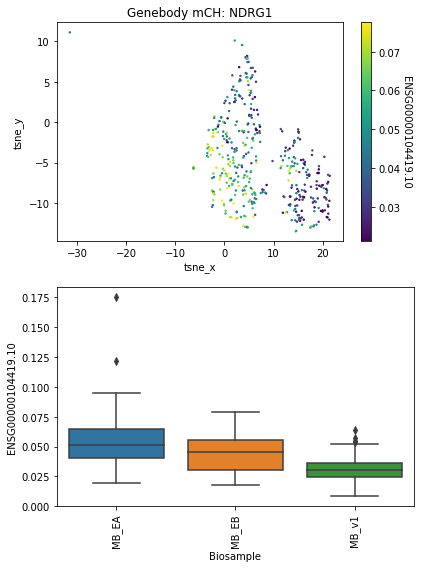

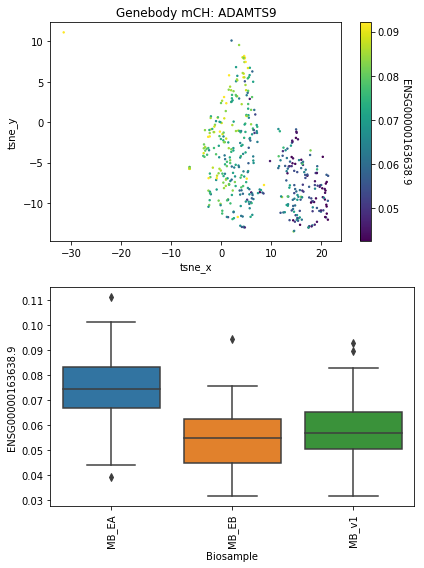

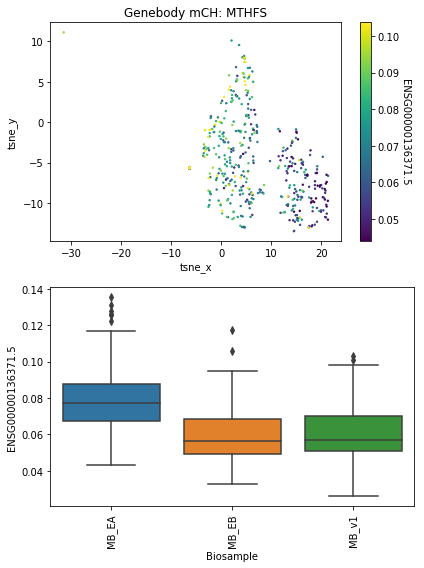

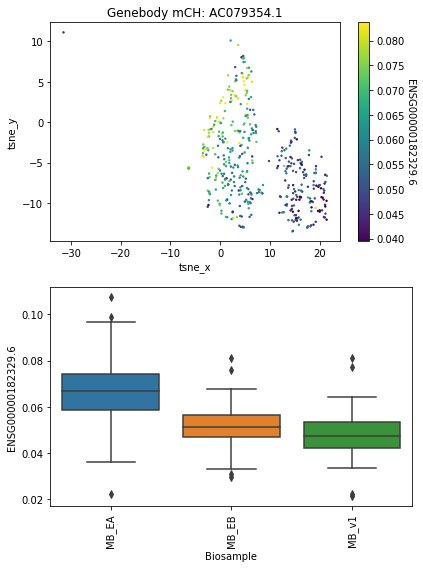

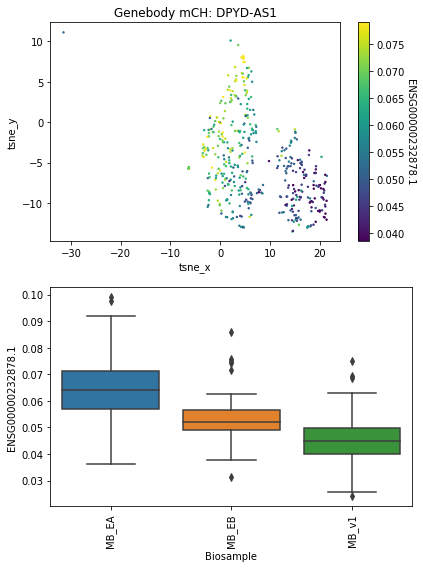

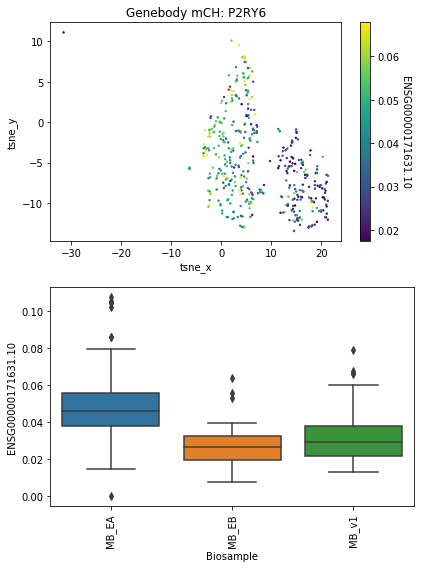

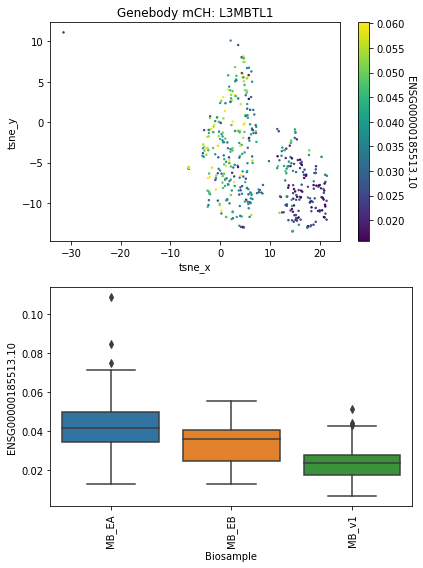

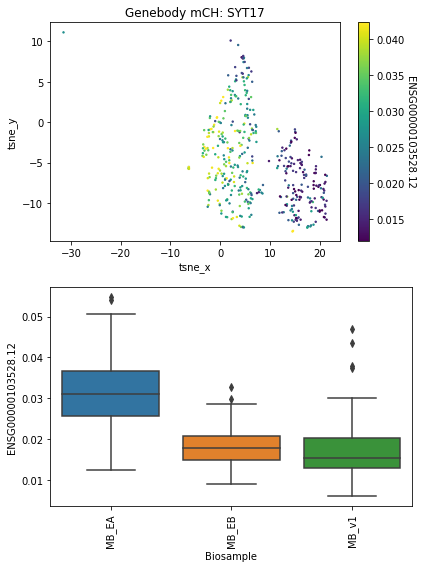

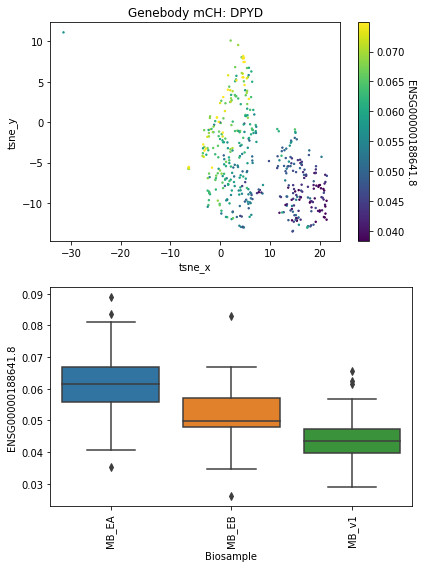

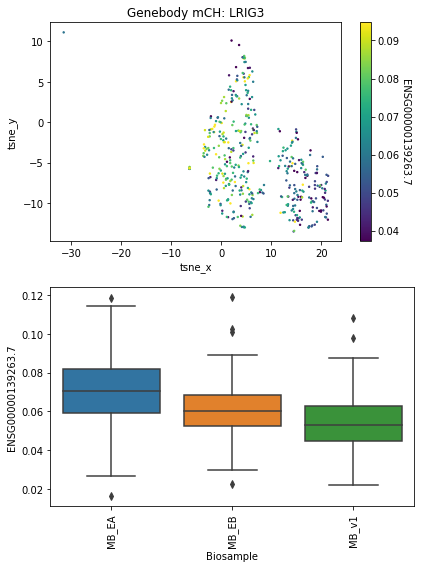

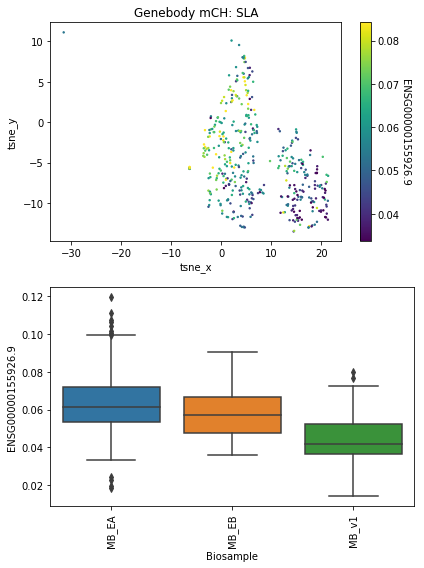

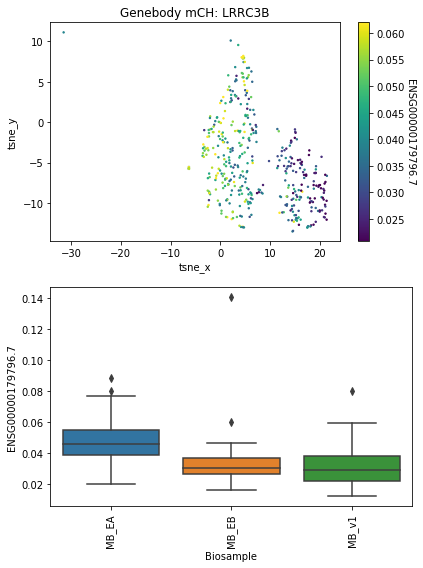

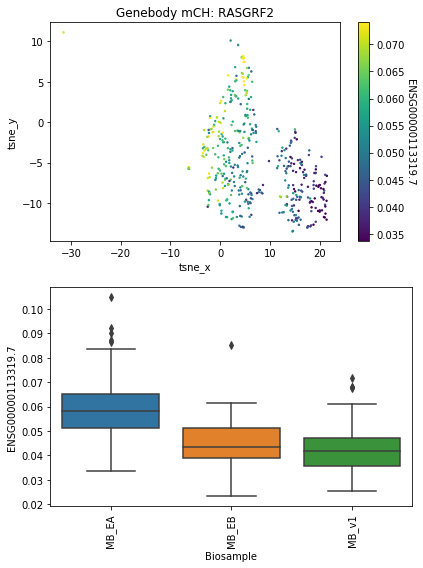

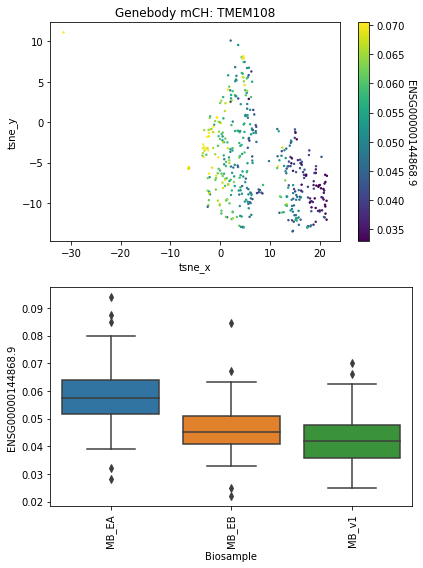

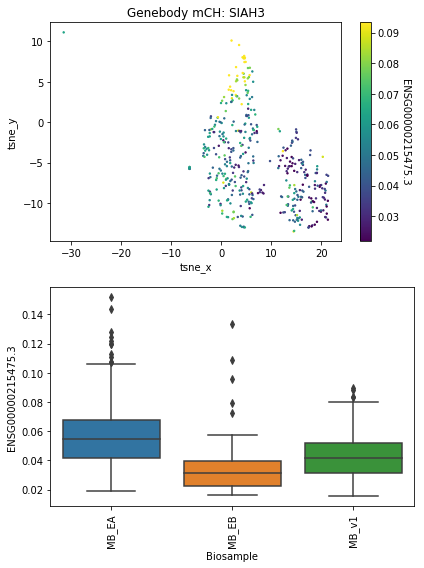

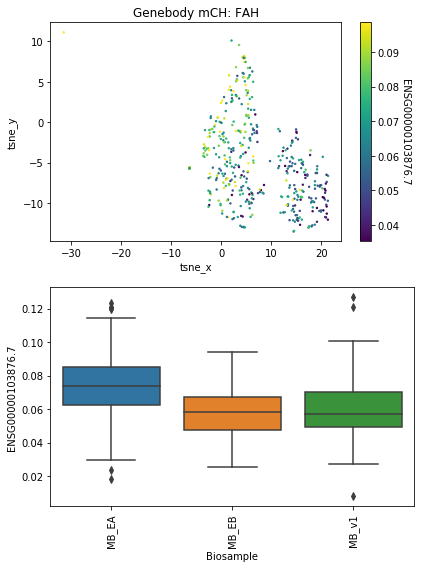

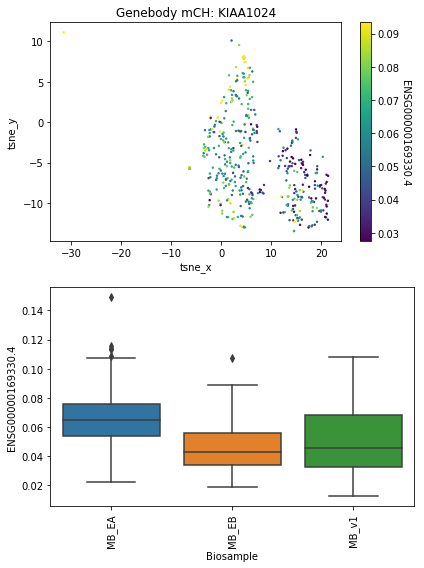

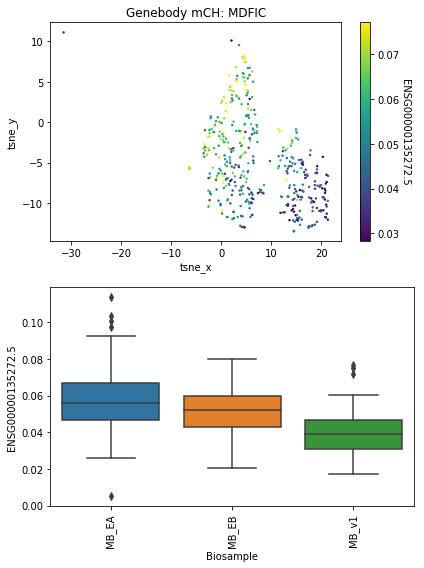

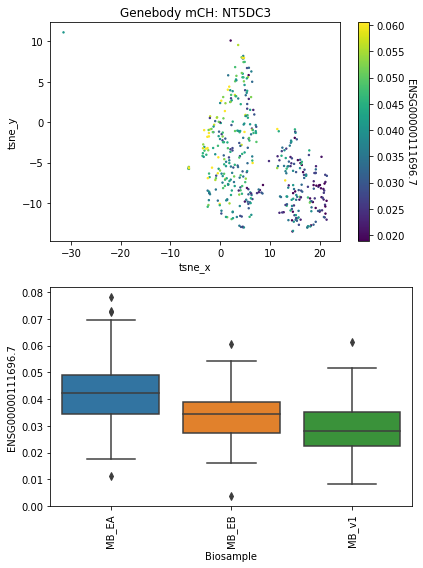

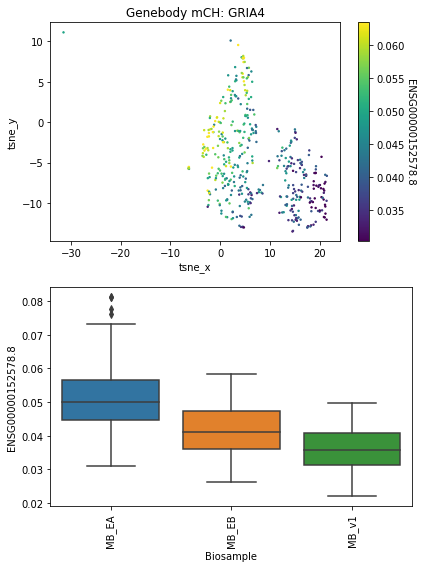

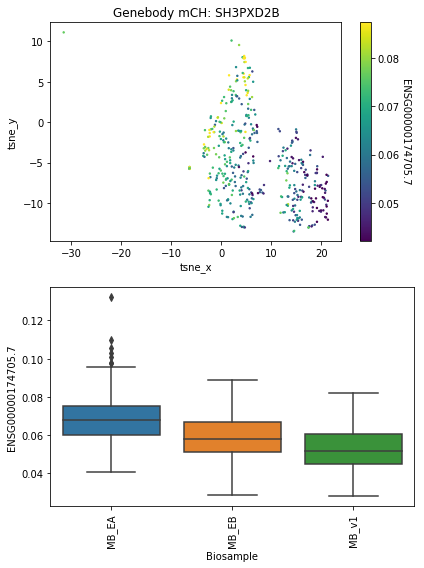

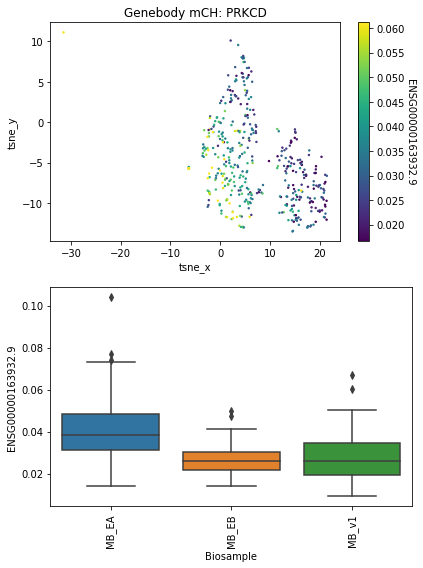

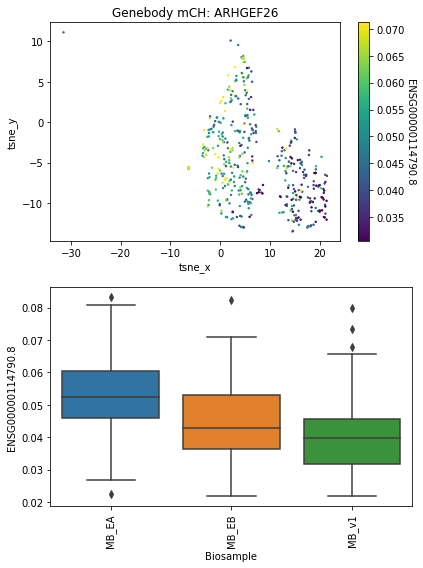

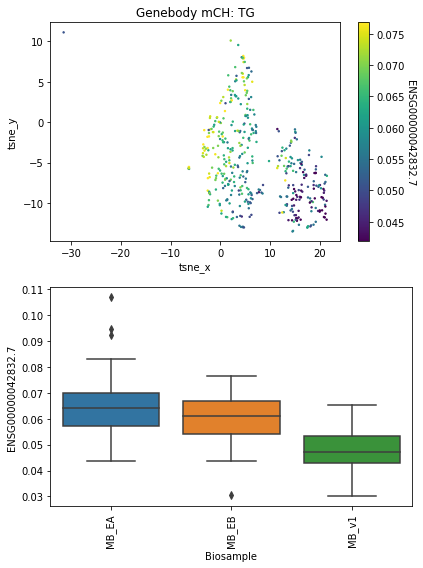

In [410]:
# tsne_box plot

for gene_id, gene_name in sr_top_genes_2.iteritems():
    df_plot = pd.merge(df_info, df_xy[[gene_id]], left_index=True, right_index=True) 
    tsne_and_boxplot(df_plot, tc=gene_id, bx='Biosample', by=gene_id,
                    output=None, show=True, close=False, 
                    title=('Genebody mCH: %s' % gene_name), 
                    figsize=(6,8),
                    t_xlim=None, t_ylim=None, b_xlim=None, b_ylim=None, 
                    low_p=5, hi_p=95)

In [416]:
# overlapping genes (genes that seperates EA from two others)

sr_top_genes_both = sr_top_genes[sr_top_genes.index.intersection(sr_top_genes_2.index)]
sr_top_genes_both.to_frame()


geneName
geneID                        
ENSG00000188641.8         DPYD
ENSG00000103528.12       SYT17
ENSG00000232878.1     DPYD-AS1
ENSG00000042832.7           TG
ENSG00000152578.8        GRIA4
ENSG00000182329.6   AC079354.1
ENSG00000214357.4      NEURL1B
ENSG00000163638.9      ADAMTS9
ENSG00000166510.9       CCDC68
ENSG00000113319.7      RASGRF2
ENSG00000144868.9      TMEM108
ENSG00000185513.10     L3MBTL1

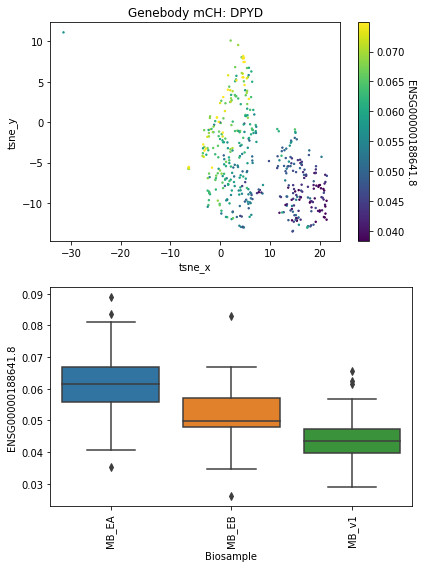

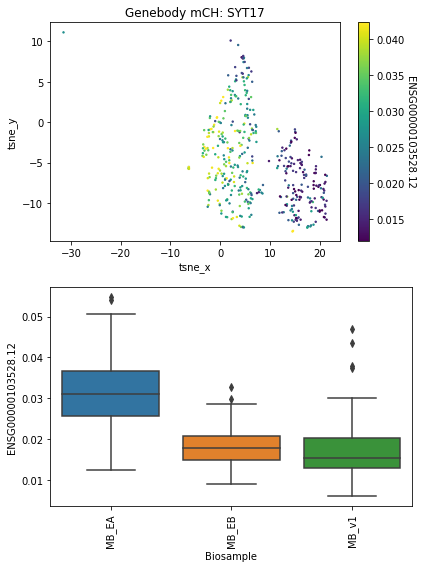

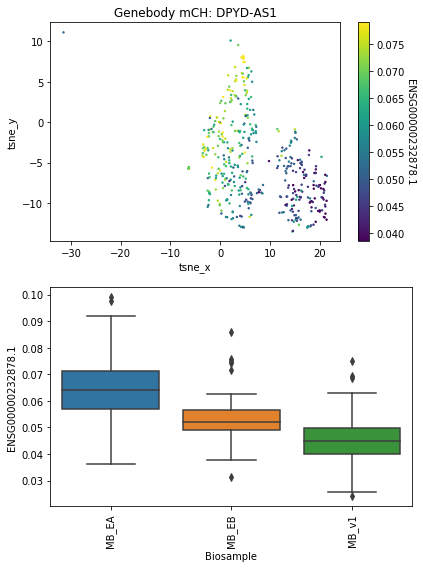

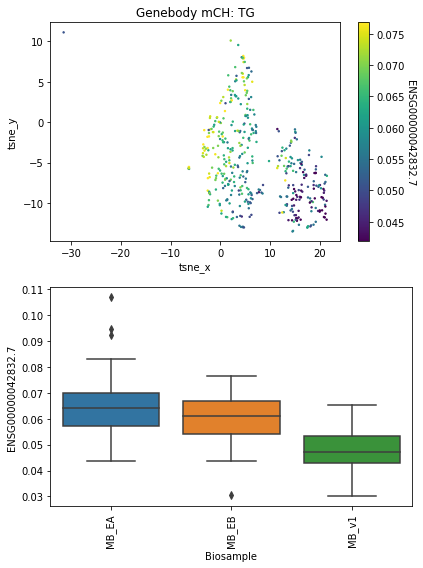

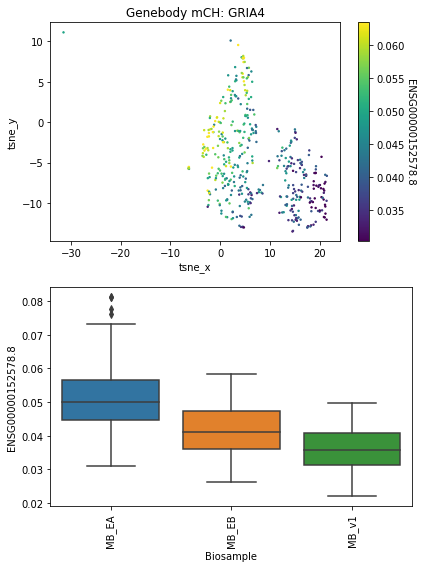

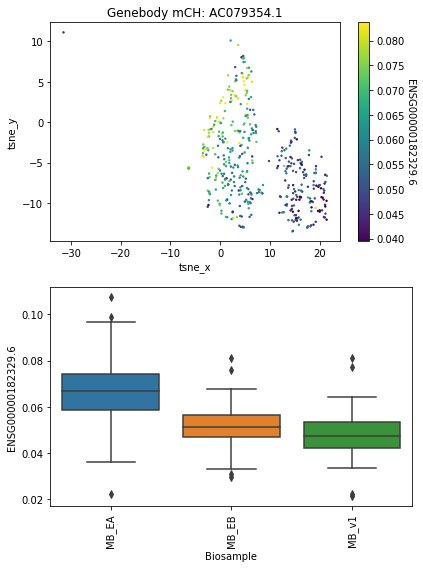

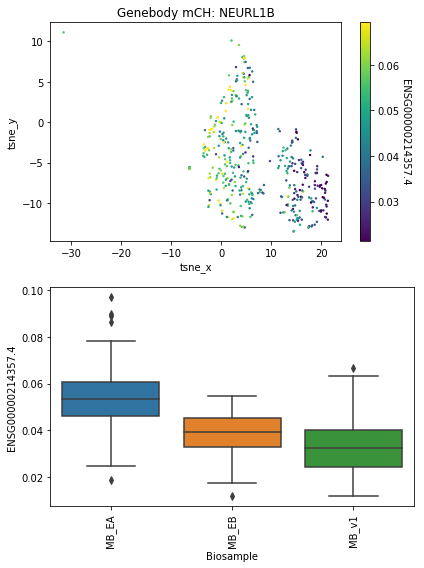

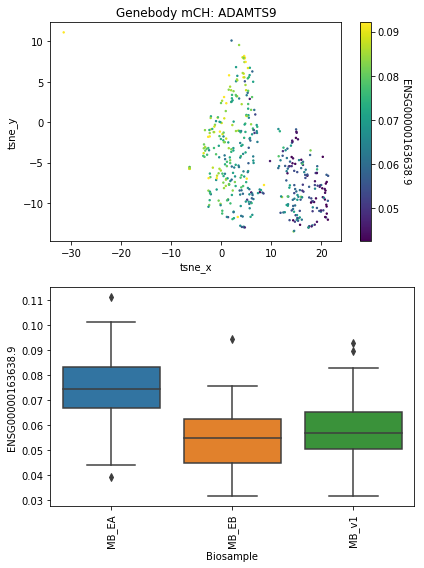

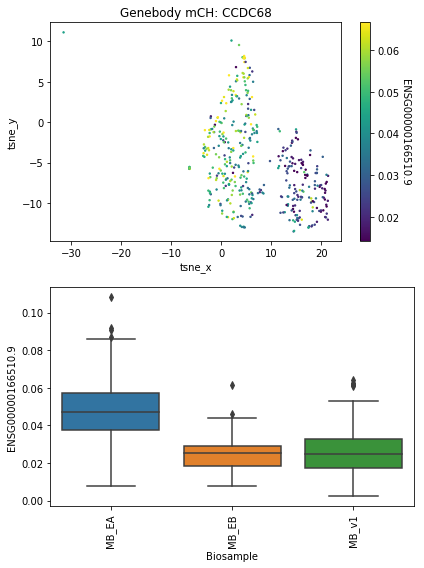

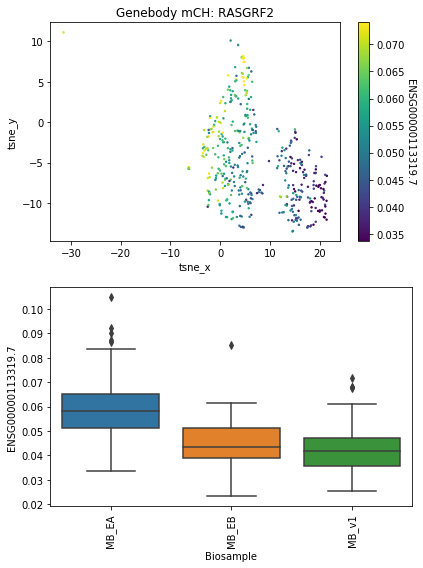

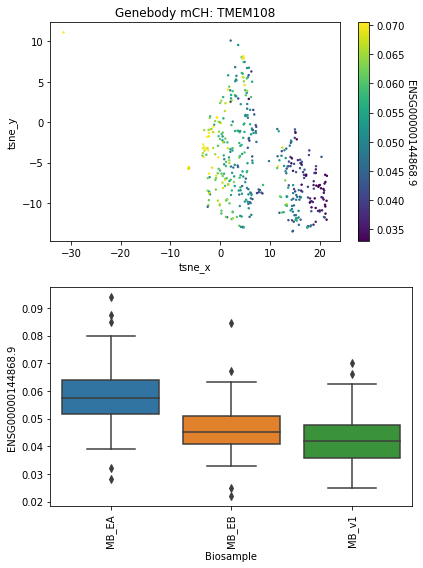

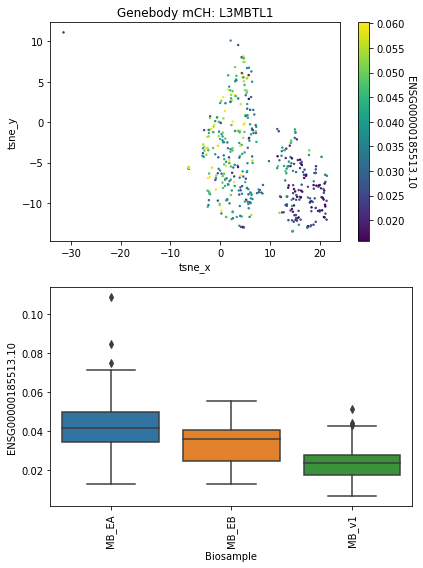

In [417]:
for gene_id, gene_name in sr_top_genes_both.iteritems():
    df_plot = pd.merge(df_info, df_xy[[gene_id]], left_index=True, right_index=True) 
    tsne_and_boxplot(df_plot, tc=gene_id, bx='Biosample', by=gene_id,
                    output=None, show=True, close=False, 
                    title=('Genebody mCH: %s' % gene_name), 
                    figsize=(6,8),
                    t_xlim=None, t_ylim=None, b_xlim=None, b_ylim=None, 
                    low_p=5, hi_p=95)

In [418]:
# those that are in list 1 but not in 2 may be genes that separates bewteen MB_v1 and MB_EB

In [2]:
# compare LDA with top ANOVA genes and LDA with random genes

In [ ]:
# find an index that show "exci v.s. inhi variance difference"

# eta-squared distribution for effect size

# if ANOVA for PV cells are skewed by few cells in MB_EB

In [ ]:
# run exactly the same analysis with mCG